# Transientness and sustainedness starting from cells

In [4]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import pool
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy as sp
import bottleneck as bt
from scipy.stats import pearsonr
from scipy.cluster import hierarchy

# except: 
import tensortools as tt
from flow.misc import wordhash
from cascade import utils
from cascade import paths
from cascade import tca
from functools import reduce

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def _update_meta_date_vec(meta):
    """
    Helper function to get change date vector in metadata to be .5 for learning
    and reversal transitions in the middle of the day.
    """
    
    day_vec = np.array(meta.reset_index()['date'].values, dtype='float')
    days = np.unique(day_vec)
    ls = meta['learning_state'].values
    for di in days:
        dboo  = np.isin(day_vec, di)
        states_vec = ls[dboo]
        u_states = np.unique(states_vec)
        if len(u_states) > 1:
            second_state = dboo & (ls == u_states[1])
            day_vec[second_state] += 0.5
    
    # replace
    new_meta = meta.reset_index()
    new_meta['date'] = day_vec
    new_meta = new_meta.set_index(['mouse', 'date', 'run', 'trial_idx'])
    
    return new_meta

In [9]:
def _update_meta_stages(meta):
    """
    Helper function to add the stage of learning to metadata.
    """
    
    stages = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
    
    meta = cas.utils.add_dprime_to_meta(meta)
    meta = _update_meta_date_vec(meta)
    u_days = np.unique(meta.reset_index()['date'])
    all_days = meta.reset_index()['date'].values
    ls = meta['learning_state'].values
    dp = meta['dprime'].values
    
    stage_vec = []
    for lsi, dpi in zip(ls, dp):
    
        if 'naive' in lsi:
            stage_vec.append('naive')
        elif 'learning' in lsi:
            if dpi < 2:
                stage_vec.append('low_dp learning')
            elif dpi >=2:
                stage_vec.append('high_dp learning')
        elif 'reversal1' in lsi:
            if dpi < 2:
                stage_vec.append('low_dp reversal1')
            elif dpi >=2:
                stage_vec.append('high_dp reversal1')
    
    meta['parsed_stage'] = stage_vec
    
    return meta

In [10]:
def _get_fitting_template_noverlap(mouse, sigma=3.5, shift=0, sec=15.5, normalize=True):
    """
    Helper function for convolving Gaussian kernel with onset, sustained 
    stimulus, stimulus offset, and ensure delivery period. These can then be
    used for simple linear regression or GLM. 
    """

    # preallocate Gaussian kernel convolution 
    gker = []
    
    # dumb params
    blur = sec/2
    lag = sec/2
    elag = sec/1.5
    # pick ranges of relevant time periods for convolution
    onset_r = [18+shift]
    if mouse in ['OA32', 'OA34', 'OA36']:
        sus_r = np.arange(np.floor(sec + lag), np.round(sec*3 + blur), 1)
        off_r = np.arange(np.floor(sec*3 + sec/4 + lag), np.round(sec*3 + sec/3 + blur), 1)
        ensure_r = np.arange(np.floor(sec*3 + sec/3 + elag), np.round(sec*5 + blur), 1)
    else:
        sus_r = np.arange(np.floor(sec + lag), np.round(sec*4 + blur), 1)
        off_r = np.arange(np.floor(sec*4 + sec/4 + lag), np.round(sec*4 + sec/3 + blur), 1)
        ensure_r = np.arange(np.floor(sec*4 + sec/3 + elag), np.round(sec*6 + blur), 1)
    ranges = [onset_r, sus_r, off_r, ensure_r]

    # convolve
    for i in ranges:
        i = [int(s) for s in i]
        starter = np.zeros((108))
        starter[i] = 1
        gker.append(sp.ndimage.gaussian_filter1d(starter, sigma, mode='constant', cval=0))

    # normalize filters
    if normalize:
        gker = [(s - np.min(s))/np.max(s) for s in gker]

    templates = np.vstack(gker).T

    return templates

In [61]:
def _get_fitting_template_10gaus(sigma=3.5, sec=15.5, lag=5, normalize=True):
    """
    Helper function for convolving Gaussian kernel with onset, sustained 
    stimulus, stimulus offset, and ensure delivery period. These can then be
    used for simple linear regression or GLM. 
    """

    # preallocate Gaussian kernel convolution 
    gker = []
    
    # dumb params
    ranges = np.arange(15.5 + lag, 108, 15.5/2)
    ranges = list(np.floor(ranges))
    ranges = [int(s) for s in ranges]
    
    # convolve
    for i in ranges:
#         i = [int(s) for s in i]
        starter = np.zeros((108))
        starter[i] = 1
        gker.append(sp.ndimage.gaussian_filter1d(starter, sigma, mode='constant', cval=0))

    # normalize filters
    if normalize:
        gker = [(s - np.min(s))/np.max(s) for s in gker]

    templates = np.vstack(gker).T

    return templates

In [12]:
def _first100_wtrans_bool(meta):
    """
    Helper function to get a boolean vector of the first 100 trials for each day.
    If a day is shorter than 100 trials use the whole day. 
    """
    
    day_vec = _update_meta_date_vec(meti).reset_index()['date'].values
    u_days = np.unique(day_vec)

    first100 = np.zeros((len(meta)))
    for di in u_days:
        dboo  = np.isin(day_vec, di)
        daylength = np.sum(dboo)
        if daylength > 100:
            first100[np.where(dboo)[0][:100]] = 1
        else:
            first100[dboo] = 1
    firstboo = first100 > 0
    
    return firstboo

In [3]:
mice = ['OA27', 'VF226', 'OA67','OA32', 'OA34', 'OA36', 'OA26']
words = ['bookmarks']
words.extend(['horrible']*6)

# load in a full size tensor
model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    out = cas.load.load_all_groupday(mouse, word=word, with_model=False, group_by='all3', nan_thresh=0.95)  # return   model, ids, tensor, meta, bhv
    model_list.append(out[0])
    tensor_list.append(out[2])
    id_list.append(out[1])
    bhv_list.append(out[4])
    meta_list.append(out[3])

Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [487]:
endframe

31

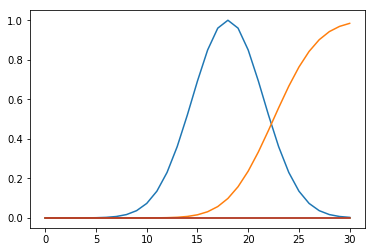

In [494]:
mi = 'OA32'
A = _get_fitting_template_noverlap(mi)

end = 5 + 1
endsec = 4
if mi in ['OA32', 'OA34', 'OA36']:
    end = 3 + 1
    endsec = 3
endsec = endsec - 1
endframe = int(np.floor(endsec*15.5))

A = A[:endframe, :]
    
plt.plot(A)

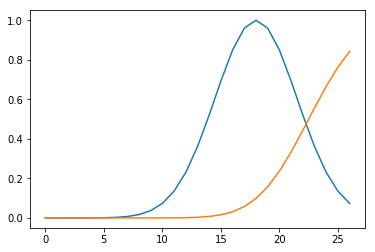

In [510]:
plt.plot(A)

In [787]:
u_days

array(['early naive', 'late naive', 'early low_dp learning',
       'late low_dp learning', 'early high_dp learning',
       'late high_dp learning', 'early low_dp reversal1',
       'late low_dp reversal1', 'early high_dp reversal1',
       'late high_dp reversal1'], dtype=object)

### NNLS fitting on all cells over all time

In [783]:
fits_control = {}
fits_control_varex = {}
fits_control_means = {}
daily_avg_dict_control = {}
oris = [0, 135, 270]
# A = np.vstack(norm_gker).T
for mi, proj, meti in zip(mice, tensor_list, meta_list):
    
    print('Starting {}...'.format(mi))
    
    meti = _update_meta_date_vec(meti)
#     meti = _update_meta_stages(meti)
    meti = cas.utils.add_10stages_to_meta(meti, simple=False)
    A = _get_fitting_template_noverlap(mi)
    all_ori = meti['orientation'].values
    all_days = meti.reset_index()['parsed_10stage'].values
    u_days = meti.reset_index()['parsed_10stage'].unique()
    firsty = _first100_wtrans_bool(meti)

    eng_boo = meti['hmm_engaged'].values | meti['learning_state'].isin(['naive']).values
    
    daily_avg_dict_control[mi] = {}
    fits_control[mi] = {}
    fits_control_varex[mi] = {}
    fits_control_means[mi] = {}
    
    end = 5 + 1
    endsec = 4
    if mi in ['OA32', 'OA34', 'OA36']:
        end = 3 + 1
        endsec = 3
#     endsec = 1.75
    endframe = int(np.floor(endsec*15.5))
    startframe = int(np.floor(15.5))
    
    A = A[:endframe, :]
    A = A[:, np.max(A, axis=0) >= 0.2]
#     A = A[:, np.max(A, axis=0) == 1]
    
    for ori in oris:
        cell_mat = np.zeros((proj.shape[0], proj.shape[1], len(u_days)))
        for dc, day_i in enumerate(u_days):
            day_ori_bool = (all_ori == ori) & (all_days == day_i) & firsty
            for c_n in range(cell_mat.shape[0]):
#                     driven_boo = simp_comp_proj_list[mi][comp_n][c_n, :] > 0
                if np.sum(day_ori_bool) > 0:
#                 if np.sum(driven_boo & day_ori_bool) > 0:
                    cell_mat[c_n, :, dc] = np.nanmean(proj[c_n, :, day_ori_bool & eng_boo], axis=0)
#                         cell_mat[c_n, :, dc] = np.nanmean(proj[comp_n][c_n, :, driven_boo & day_ori_bool & eng_boo], axis=0)
        
        # normalize each cell to max over all stages
        cell_mat = cell_mat/np.nanmax(np.nanmax(cell_mat, axis=2, keepdims=True), axis=1, keepdims=True)
        
        all_tr = np.zeros((proj.shape[0], A.shape[1], len(u_days)))
        all_varex = np.zeros((proj.shape[0], 1, len(u_days)))
        all_means = np.zeros((proj.shape[0], 2, len(u_days)))
        for tr_n in range(cell_mat.shape[2]):
            for c_n in range(cell_mat.shape[0]):
                b = deepcopy(cell_mat[c_n, :, tr_n])
                b_bool = b < 0
                b_copy = deepcopy(b)
                b[b_bool] = 0
#                 b = b/np.nanmax(b)
                b = b[:endframe]
                if np.sum(np.isnan(b)) == len(b):
                    meany = np.zeros(2)
                    meany[:] = np.nan
                    sp_ans = np.zeros(A.shape[1])
                    sp_ans[:] = np.nan
                    varex = np.nan
                else:
                    meany = np.zeros(2)
                    b_copy[b_bool] = np.nan
#                     b_copy = b_copy/np.nanmax(b_copy)
                    meany[0] = np.nanmean(b_copy[startframe:startframe+15])
                    meany[1] = np.nanmean(b_copy[endframe-15:endframe])
                    sp_ans = sp.optimize.nnls(A, b)[0]
                    recon = A@sp_ans[:, None].flatten()
                    varex = 1 - np.var(b-recon)/np.var(b)
                    
                if sp_ans[0] == 0 and sp_ans[1] == 0:
                    sp_ans[0] = np.nan
                    sp_ans[1] = np.nan
                    print('    double zero fit')
                all_tr[c_n, :, tr_n] = sp_ans
                all_varex[c_n, :, tr_n] = varex
                all_means[c_n, :, tr_n] = meany
        fits_control[mi]['ori_{}'.format(ori)] = all_tr
        fits_control_varex[mi]['ori_{}'.format(ori)] = all_varex
        fits_control_means[mi]['ori_{}'.format(ori)] = all_means
        fits_control[mi]['trial_inds_{}'.format(ori)] = np.where(all_ori == ori)[0]
        daily_avg_dict_control[mi]['ori_{}'.format(ori)] = cell_mat
        
        print('    varex: {}'.format(np.nanmean(all_varex, axis=0)))

    print('Making progress: {} done.\n'.format(mi))

Starting OA27...


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: Mean of empty slice


    varex: [[0.25920995 0.35430741 0.168128   0.24250552 0.18845677 0.18717644
  0.13759626 0.16985284 0.23895044 0.20411597]]
    varex: [[0.30061299 0.34198922 0.25423137 0.26966319 0.1971165  0.16924799
  0.20765386 0.17942964 0.24078558 0.21927831]]
    varex: [[0.27600567 0.30711657 0.21634121 0.30074403 0.25899025 0.28679792
  0.24747884 0.26329596 0.2503323  0.20379672]]
Making progress: OA27 done.

Starting VF226...
    varex: [[0.25121682 0.26426264 0.23399954 0.22572115 0.22691285 0.15248734
  0.16894522 0.14349042 0.18536002 0.15812853]]
    varex: [[0.28694206 0.22202072 0.1397911  0.17795928 0.19855279 0.202452
  0.11462687 0.09082537 0.10026899 0.15819631]]
    varex: [[0.24104928 0.25579643 0.20857923 0.1639517  0.18858072 0.18113765
  0.15794739 0.12606311 0.17542147 0.14519228]]
Making progress: VF226 done.

Starting OA67...
    varex: [[0.23572779 0.25369418 0.17750099 0.29506693 0.25330803 0.24553154
  0.1870876  0.27273654 0.27274316 0.22192887]]
    double zero fit

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN slice encountered


    varex: [[0.16957742 0.26567665 0.25007427 0.15916544 0.2214119 ]]
    varex: [[0.22361926 0.26772455 0.22252473 0.1434686  0.22185552]]
Making progress: OA36 done.

Starting OA26...
    varex: [[0.19893653 0.10804185 0.18517834 0.12143795 0.13499859 0.13876298
  0.19828997 0.1331809  0.07526416 0.14677878]]
    double zero fit
    double zero fit
    varex: [[0.21343349 0.15957856 0.16172892 0.14030568 0.11078587 0.1371584
  0.15655836 0.14543029 0.12175078 0.18185361]]
    varex: [[0.17856195 0.07924609 0.1947733  0.23898527 0.18859814 0.16971783
  0.16009444 0.14515242 0.09113914 0.14616571]]
Making progress: OA26 done.



In [609]:
fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])].shape

(703, 1, 5)

In [591]:
fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])]

'OA36'

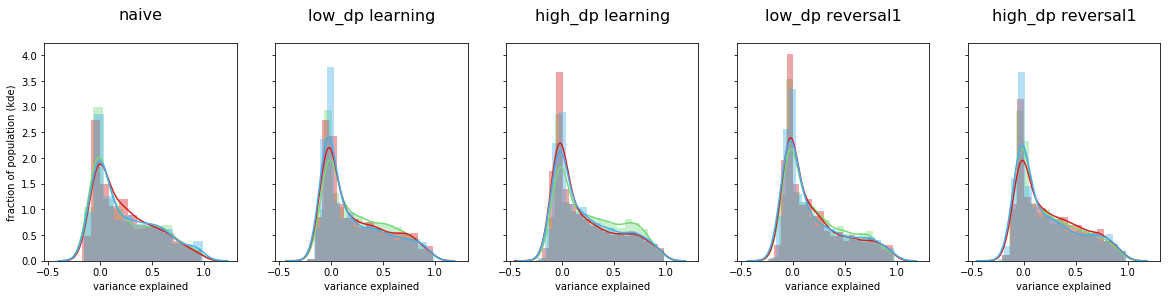

In [755]:
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for stagi in range(5):
    for oik in ['plus', 'minus', 'neutral']:
        alta_list = []
        for mi in mice:
                
            if mi in ['OA32', 'OA34', 'OA36'] and stagi == 0:
                alta = np.zeros(fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
                alta_list.append(alta)
            elif mi in ['OA36'] and stagi == 4:
                alta = np.zeros(fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
                alta_list.append(alta)
            else:
                if mi in ['OA32', 'OA34', 'OA36']:
                    dexer = stagi - 1
                else:
                    dexer = stagi
                alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, dexer].squeeze()
                alta_list.append(alta)
                
        alta = np.hstack(alta_list)
        alta = alta[np.isfinite(alta)]
        sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi], hist=True);
        ax[stagi].set_title(title_stage[stagi] + '\n', size=16)
    ax[stagi].set_xlabel('variance explained')
ax[0].set_ylabel('fraction of population (kde)');

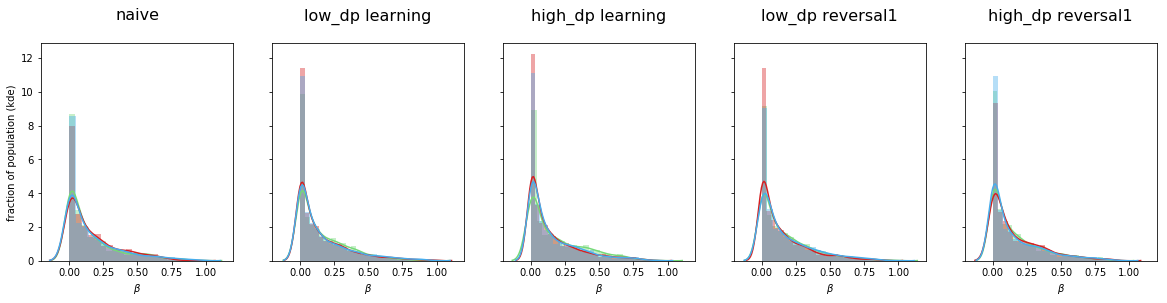

In [756]:
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for stagi in range(5):
    for oik in ['plus', 'minus', 'neutral']:
#         alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi].squeeze()
        alta_list = []
        for mi in mice:
            if mi in ['OA32', 'OA34', 'OA36'] and stagi == 0:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
                alta_list.append(alta)
            elif mi in ['OA36'] and stagi == 4:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
                alta_list.append(alta)
            else:
                if mi in ['OA32', 'OA34', 'OA36']:
                    dexer = stagi - 1
                else:
                    dexer = stagi
                alta = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
                alta_list.append(alta)
                
        alta = np.hstack(alta_list)
        alta = alta[np.isfinite(alta)]
        
        sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi], hist=True)
        ax[stagi].set_title(title_stage[stagi] + '\n', size=16)
    ax[stagi].set_xlabel(r'$\beta$')
ax[0].set_ylabel('fraction of population (kde)');

In [697]:
mi = 'OA27'
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
# fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for oik in ['minus', 'plus', 'neutral']:
    each_stage = []
    for stagi in range(5):
        vart = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi].squeeze()
        trans = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, stagi].squeeze()
        sus = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, stagi].squeeze()
        alta = trans/(trans+sus)
#         trans = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, stagi+1].squeeze()
#         sus = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, stagi+1].squeeze()
#         alta2 = trans/(trans+sus)
#         booyah = np.isfinite(alta) & np.isfinite(alta2)
#         alta = alta[booyah]
#         alta2 = alta2[booyah]
        diff_alta = alta #- alta2
        diff_alta[vart < 0.1] = np.nan
#         diff_alta[(alta == 0) | (alta == 1) |(alta2 == 0) | (alta2 == 1)] = np.nan
        each_stage.append(diff_alta)
    diff_mat = np.vstack(each_stage)
    diff_mat[:, np.sum(np.isfinite(diff_mat), axis=0) <= 1] = np.nan
    print('Cell across all time: {}'.format(np.sum(np.sum(np.isfinite(diff_mat), axis=0) > 1)))
    break
#         ax[stagi].set_title(title_stage[stagi] + '\n', size=16)
#     ax[stagi].set_xlabel(r'$\beta$')
# ax[0].set_ylabel('fraction of population (kde)')

Cell across all time: 250


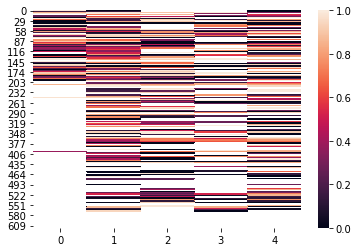

In [698]:
# sorter = np.argsort(diff_mat[1,:])[::-1]
sns.heatmap(diff_mat.T[:, :])

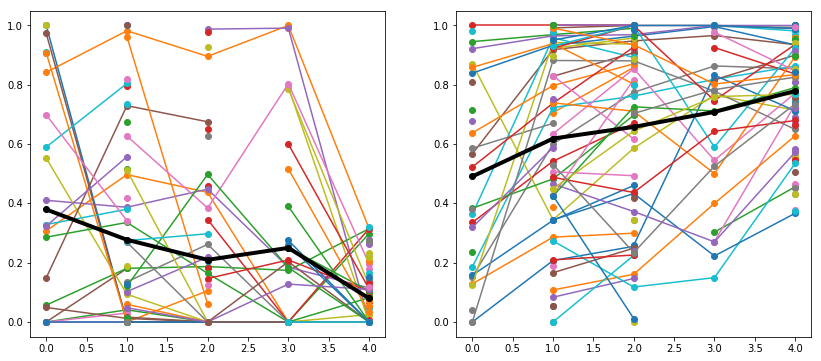

In [699]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(diff_mat[:, diff_mat[-1, :] < 0.33], 'o-');
ax[0].plot(np.nanmean(diff_mat[:, diff_mat[-1, :] < 0.33], axis=1), 'o-k', linewidth=4);
ax[1].plot(diff_mat[:, diff_mat[-1, :] >= 0.33], 'o-');
ax[1].plot(np.nanmean(diff_mat[:, diff_mat[-1, :] >= 0.33], axis=1), 'o-k', linewidth=4);

In [749]:
np.log2(1)

0.0

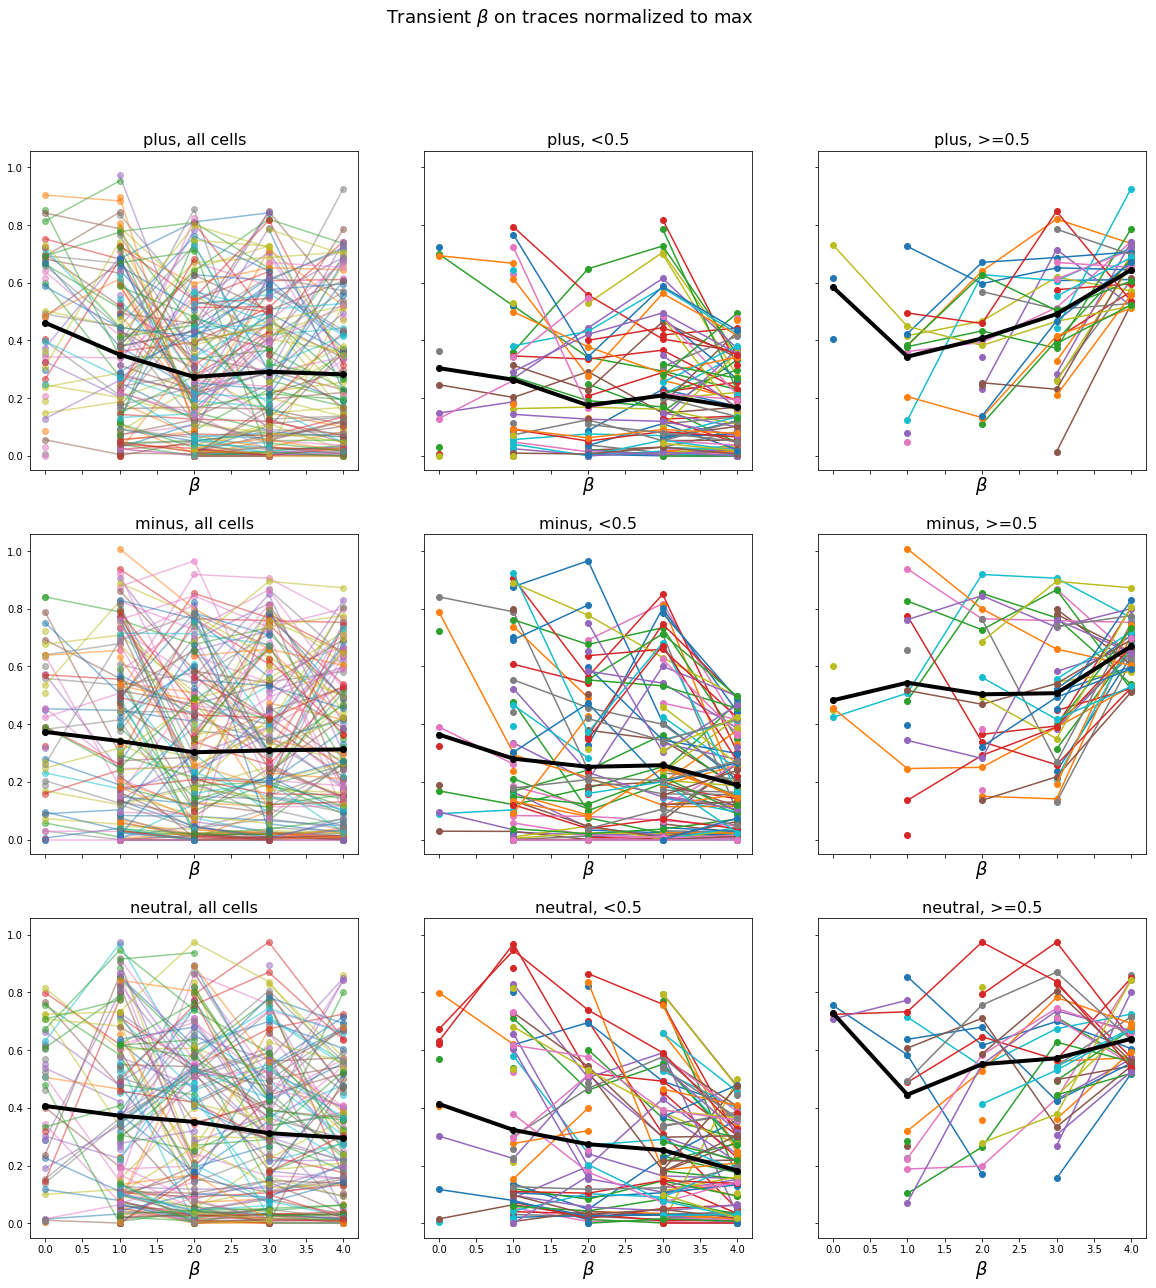

In [791]:
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharey=True, sharex=True)
for oic, oik in enumerate(['plus', 'minus', 'neutral']):
    stage_list = []
    for stagi in range(5):
#         alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi].squeeze()
        alta_list = []
        for mi in mice:
            if mi in ['OA32', 'OA34', 'OA36'] and stagi == 0:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
            elif mi in ['OA36'] and stagi == 4:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
            else:
                if mi in ['OA32', 'OA34', 'OA36']:
                    dexer = stagi - 1
                else:
                    dexer = stagi
                vart = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, dexer].squeeze()
                trans = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, dexer].squeeze()
                sus = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
                trans_m = fits_control_means[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, dexer].squeeze()
                sus_m = fits_control_means[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
#                 alta = trans_m/(trans_m+sus_m)
#                 alta = np.log2(sus_m/trans_m)
                alta = sus
#                 alta = sus/(trans + sus)
#                 alta = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
                alta[vart < 0.6] = np.nan
                
            alta_list.append(alta)
              
        stage_list.append(np.hstack(alta_list))
        
#         alta = alta[np.isfinite(alta)]
    diff_mat = np.vstack(stage_list)
    diff_mat[:, np.sum(np.isfinite(diff_mat), axis=0) <= 1] = np.nan
    
    sort_stage = -1
    break_thresh = 0.5
    ax[oic, 0].plot(diff_mat, 'o-', alpha=0.5);
    ax[oic, 0].plot(np.nanmean(diff_mat, axis=1), 'o-k', linewidth=4);
    ax[oic, 1].plot(diff_mat[:, diff_mat[sort_stage, :] < break_thresh], 'o-');
    ax[oic, 1].plot(np.nanmean(diff_mat[:, diff_mat[sort_stage, :] < break_thresh], axis=1), 'o-k', linewidth=4);
    ax[oic, 2].plot(diff_mat[:, diff_mat[sort_stage, :] >= break_thresh], 'o-');
    ax[oic, 2].plot(np.nanmean(diff_mat[:, diff_mat[sort_stage, :] >= break_thresh], axis=1), 'o-k', linewidth=4);

#     sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi], hist=True)
    
    ax[oic, 0].set_title('{}, all cells'.format(oik), size=16)
    ax[oic, 1].set_title('{}, <{}'.format(oik, break_thresh), size=16)
    ax[oic, 2].set_title('{}, >={}'.format(oik, break_thresh), size=16)
    ax[oic, 0].set_xlabel(r'$\beta$', size=18)
    ax[oic, 1].set_xlabel(r'$\beta$', size=18)
    ax[oic, 2].set_xlabel(r'$\beta$', size=18)
    if stagi == 0:
        ax[oic, stagi].set_ylabel('fraction of population (kde)')
    
plt.suptitle(r'Transient $\beta$ on traces normalized to max', size=18);

In [788]:
fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])].shape
mi

'OA36'

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


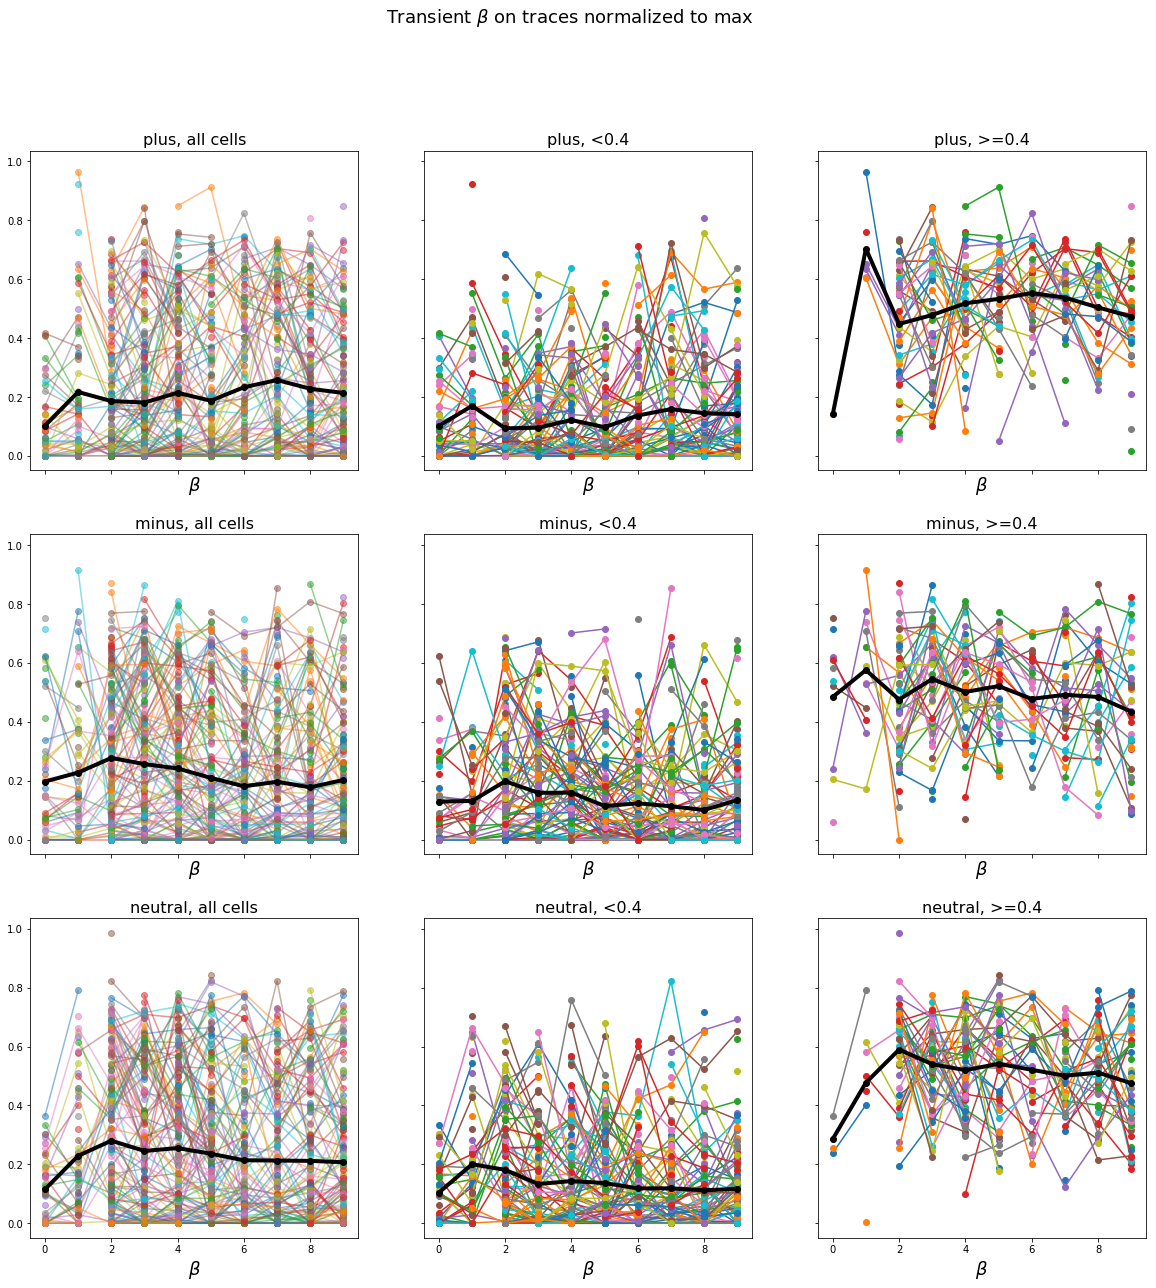

In [790]:
# 10 stage


# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharey=True, sharex=True)
for oic, oik in enumerate(['plus', 'minus', 'neutral']):
    stage_list = []
    for stagi in range(10):
#         alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi].squeeze()
        alta_list = []
        for mi in mice:
            if mi in ['OA36']:
                continue
            if mi in ['OA32', 'OA34', 'OA36'] and stagi <= 1:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
            elif mi in ['OA36'] and stagi >= 8:
                alta = np.zeros(fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, 0].squeeze().shape[0])
                alta[:] = np.nan
            else:
                if mi in ['OA32', 'OA34', 'OA36']:
                    dexer = stagi - 2
                else:
                    dexer = stagi
                vart = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, dexer].squeeze()
                trans = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, dexer].squeeze()
                sus = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
                trans_m = fits_control_means[mi]['ori_{}'.format(lookup[mi][oik])][:, 0, dexer].squeeze()
                sus_m = fits_control_means[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
#                 alta = trans_m/(trans_m+sus_m)
#                 alta = np.log2(sus_m/trans_m)
#                 alta = trans
                alta = trans #/(trans + sus)
#                 alta = fits_control[mi]['ori_{}'.format(lookup[mi][oik])][:, 1, dexer].squeeze()
                alta[vart < 0.6] = np.nan
                
            alta_list.append(alta)
              
        stage_list.append(np.hstack(alta_list))
        
#         alta = alta[np.isfinite(alta)]
    diff_mat = np.vstack(stage_list)
    diff_mat[:, np.sum(np.isfinite(diff_mat), axis=0) <= 1] = np.nan
    
    sort_stage = -5
    break_thresh = 0.4
    ax[oic, 0].plot(diff_mat, 'o-', alpha=0.5);
    ax[oic, 0].plot(np.nanmean(diff_mat, axis=1), 'o-k', linewidth=4);
    ax[oic, 1].plot(diff_mat[:, np.nanmean(diff_mat[:, :], axis=0) < break_thresh], 'o-');
    ax[oic, 1].plot(np.nanmean(diff_mat[:, np.nanmean(diff_mat[:, :], axis=0) < break_thresh], axis=1), 'o-k', linewidth=4);
    ax[oic, 2].plot(diff_mat[:, np.nanmean(diff_mat[:, :], axis=0) >= break_thresh], 'o-');
    ax[oic, 2].plot(np.nanmean(diff_mat[:, np.nanmean(diff_mat[:, :], axis=0) >= break_thresh], axis=1), 'o-k', linewidth=4);

#     sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi], hist=True)
    
    ax[oic, 0].set_title('{}, all cells'.format(oik), size=16)
    ax[oic, 1].set_title('{}, <{}'.format(oik, break_thresh), size=16)
    ax[oic, 2].set_title('{}, >={}'.format(oik, break_thresh), size=16)
    ax[oic, 0].set_xlabel(r'$\beta$', size=18)
    ax[oic, 1].set_xlabel(r'$\beta$', size=18)
    ax[oic, 2].set_xlabel(r'$\beta$', size=18)
    if stagi == 0:
        ax[oic, stagi].set_ylabel('fraction of population (kde)')
    
plt.suptitle(r'Transient $\beta$ on traces normalized to max', size=18);

In [773]:
diff_mat.shape

(10, 3281)

In [ ]:
epoch_diff = 3
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
ax[0].plot(diff_mat[:, diff_mat[epoch_diff, :] > 0.2]);
ax[1].plot(diff_mat[:, diff_mat[epoch_diff, :] < -0.2]);
ax[2].plot(diff_mat[:, (diff_mat[epoch_diff, :] >= -0.2) & (diff_mat[epoch_diff, :] <= 0.2)]);

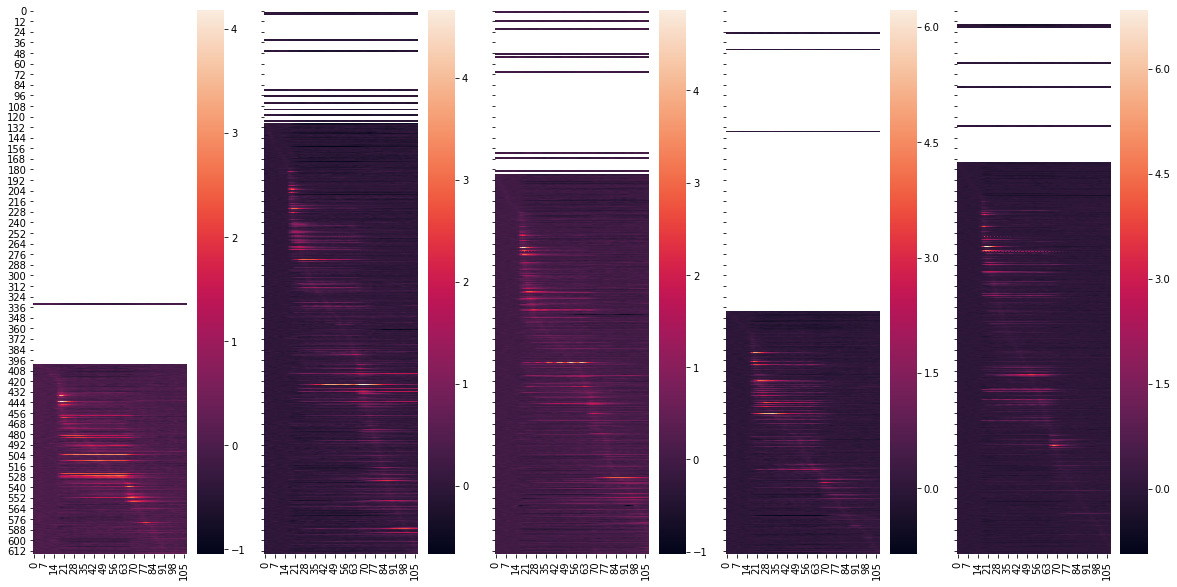

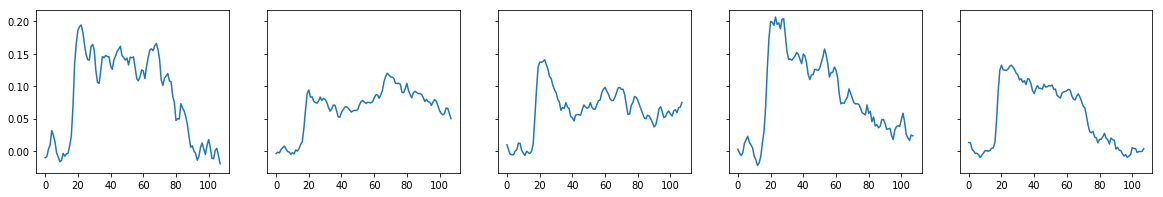

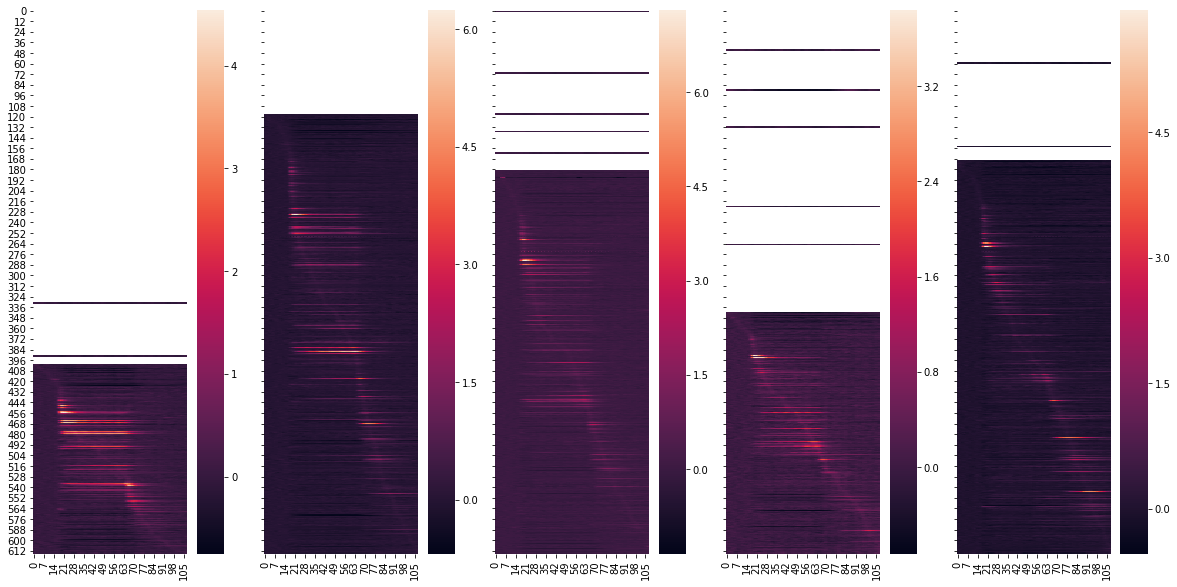

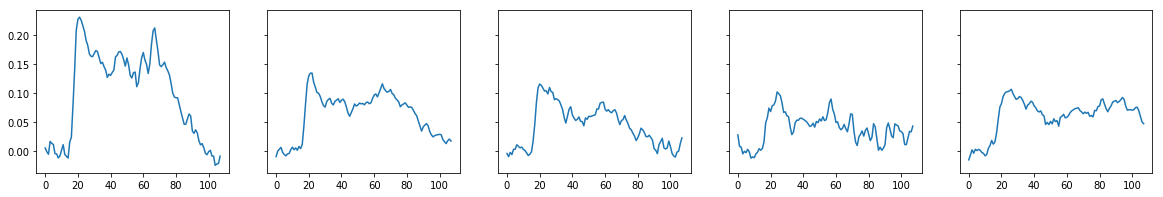

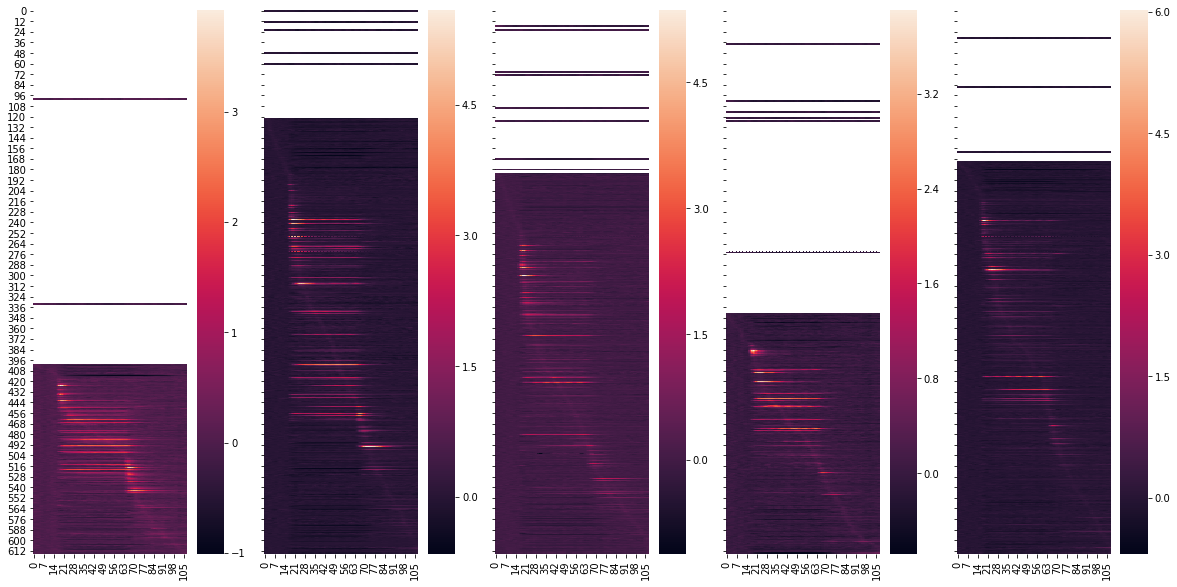

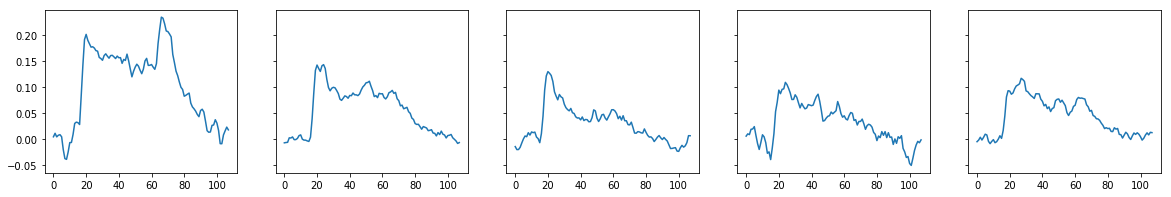

In [644]:
mi = 'OA27'
ori = 270
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']

for oik in ['plus', 'minus', 'neutral']:
    fig, ax = plt.subplots(1, 5, figsize=(20, 10), sharey=True, sharex=True)
    fig2, ax2 = plt.subplots(1, 5, figsize=(20, 3), sharey=True, sharex=True)
    for stagi in range(5):
        mat_stag = daily_avg_dict_control[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi]
        mat_sort = np.argsort(np.argmax(mat_stag, axis=1))
        sns.heatmap(mat_stag[mat_sort, :], ax=ax[stagi])
        
        ax2[stagi].plot(np.nanmean(mat_stag, axis=0))

In [596]:
betas.shape
sus_cols
mi

'OA36'

In [597]:
jitter_please = False
kill_zeros = False
use_varex = False
use_varex_10g = True
varex_thresh = 0.4
use_log10 = False

lookup = cas.lookups.lookup

# plt.figure(figsize=(8,8))
all_ori_list = []
for oi in ['plus', 'minus', 'neutral']:
    done = False
    df_list = []
    for c, mi in enumerate(mice):
        if mi in ['OA36']:
            sus_cols = ['low_dp learning', 'high_dp learning', 'low_dp reversal1']
        elif mi in ['OA32', 'OA34']:
            high_dp_ind = 1
            high_dp_rev = 3
            sus_filt_n = 3
            sus_filt_g = 5
            sus_filt_log = 5
            sus_cols = ['low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
        else:
            high_dp_ind = 2
            high_dp_rev = 4
            sus_filt_n = 5
            sus_filt_g = 7
            sus_filt_log = 6
            sus_cols = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']

        for wind in ['transient', 'sustained', 'sus_index', 'trans_index', 'vis_stimulus']:
            
            trans_betas = deepcopy(fits_control[mi]['ori_{}'.format(lookup[mi][oi])][:, 0, :])
            sus_betas = deepcopy(fits_control[mi]['ori_{}'.format(lookup[mi][oi])][:, 1, :])
            stim_betas = np.nanmean(fits_control[mi]['ori_{}'.format(lookup[mi][oi])][:, 0:2, :], axis=1)

            if use_varex:
                ori_stage_list = []
                for oik in ['plus', 'minus', 'neutral']:
                    alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])]
                    ori_stage_list.append(alta.squeeze()[:,:,None])
                all_oris = np.concatenate(ori_stage_list, axis=2)
                max_p = np.nanmax(all_oris, axis=2)
#                     nama = fits_control_varex[mi][comp_n]['ori_{}'.format(lookup[mi][oi])].squeeze()
                nama = max_p
                trans_betas[nama < varex_thresh] = np.nan
                sus_betas[nama < varex_thresh] = np.nan
                stim_betas[nama < varex_thresh] = np.nan
                
            if use_varex_10g:
                ori_stage_list = []
                trans_all_ori_list = []
                sus_all_ori_list = []
                for oik in ['plus', 'minus', 'neutral']:
#                     alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, :]
                    alta = fits_control_varex[mi]['ori_{}'.format(lookup[mi][oik])]
                    ori_stage_list.append(alta.squeeze()[:,:,None])
#                     alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 0, :]
#                     trans_all_ori_list.append(alta.squeeze()[:,:,None])
#                     alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 1, :]
#                     sus_all_ori_list.append(alta.squeeze()[:,:,None])
                all_oris = np.concatenate(ori_stage_list, axis=2)
                max_total = np.nanmax(all_oris, axis=2)
                max_epoch = np.nanmax(max_total, axis=1)
#                 all_trans = np.concatenate(trans_all_ori_list, axis=2)
#                 max_trans = np.nanmax(all_trans, axis=2)
#                 all_sus = np.concatenate(sus_all_ori_list, axis=2)
#                 max_sus = np.nanmax(all_sus, axis=2)
#                     nama = fits_10var_varex[mi][comp_n]['ori_{}'.format(lookup[mi][oi])].squeeze()
                condition_bool = (max_total > varex_thresh) #& ((max_trans > 0) | (max_sus > 0))
#                 condition_ep_bool = (max_epoch > varex_thresh)
                trans_betas[~condition_bool] = np.nan
                sus_betas[~condition_bool] = np.nan
                stim_betas[~condition_bool] = np.nan
#                 trans_betas[~condition_ep_bool, :] = np.nan
#                 sus_betas[~condition_ep_bool, :] = np.nan
#                 stim_betas[~condition_ep_bool, :] = np.nan

            if use_log10:
                trans_betas = np.log10(trans_betas)
                sus_betas = np.log10(sus_betas)
                stim_betas = np.log10(stim_betas)

            # get most driven ori across all stages of learning 
            pa = np.nanmean(np.nanmean(fits_control[mi]['ori_{}'.format(lookup[mi]['plus'])][:, 0:2, :], axis=1), axis=1)
            ma = np.nanmean(np.nanmean(fits_control[mi]['ori_{}'.format(lookup[mi]['minus'])][:, 0:2, :], axis=1), axis=1)
            na = np.nanmean(np.nanmean(fits_control[mi]['ori_{}'.format(lookup[mi]['neutral'])][:, 0:2, :], axis=1), axis=1)

            pmn_mat = np.vstack([pa, ma, na])
            pmn_text = ['plus', 'minus', 'neutral']
            best_pmn = np.argmax(pmn_mat, axis=0)
            driven_by = ['initial_{}'.format(pmn_text[s]) for s in best_pmn]
            
            if wind == 'transient':
                betas = trans_betas
            elif wind == 'sustained':
                betas = sus_betas
            elif wind == 'sus_index':
                betas = sus_betas/(trans_betas + sus_betas)
            elif wind == 'trans_index':
                betas = trans_betas/(trans_betas + sus_betas)
            elif wind == 'vis_stimulus':
                betas = stim_betas
            
            if kill_zeros:
                betas[betas == 0] = np.nan
                
            if jitter_please:
                jitter_mat = (np.random.rand(betas.shape[0], betas.shape[1]) - 0.5)/25
                betas += jitter_mat

            ori_sus_cols = ['initial_{} {}'.format(oi, s) for s in sus_cols]
            data_df = pd.DataFrame(betas, columns=sus_cols)
            data_df['mouse'] = [mi]*len(data_df)
            data_df['orientation'] = ['initial_{}'.format(oi)]*len(data_df)
            data_df['cell_number'] = np.arange(len(data_df))
            data_df['response_type'] = [wind]*len(data_df)
            data_df['driven_by'] = driven_by

            df_list.append(data_df)
    
    all_mouse_df = pd.concat(df_list, axis=0, sort=False)
    all_ori_list.append(all_mouse_df)

big_df = pd.concat(all_ori_list, axis=0)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice


In [598]:
big_df.loc[big_df['mouse'].isin(['OA36'])].head()

naive  low_dp learning  high_dp learning  low_dp reversal1  \
0    NaN         0.136756               NaN               NaN   
1    NaN         0.072347          0.554728          0.590632   
2    NaN              NaN          0.000000               NaN   
3    NaN              NaN               NaN          0.744917   
4    NaN              NaN          0.588291          0.718377   

   high_dp reversal1 mouse   orientation  cell_number response_type  \
0                NaN  OA36  initial_plus            0     transient   
1                NaN  OA36  initial_plus            1     transient   
2                NaN  OA36  initial_plus            2     transient   
3                NaN  OA36  initial_plus            3     transient   
4                NaN  OA36  initial_plus            4     transient   

       driven_by  
0  initial_minus  
1   initial_plus  
2   initial_plus  
3   initial_plus  
4   initial_plus

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

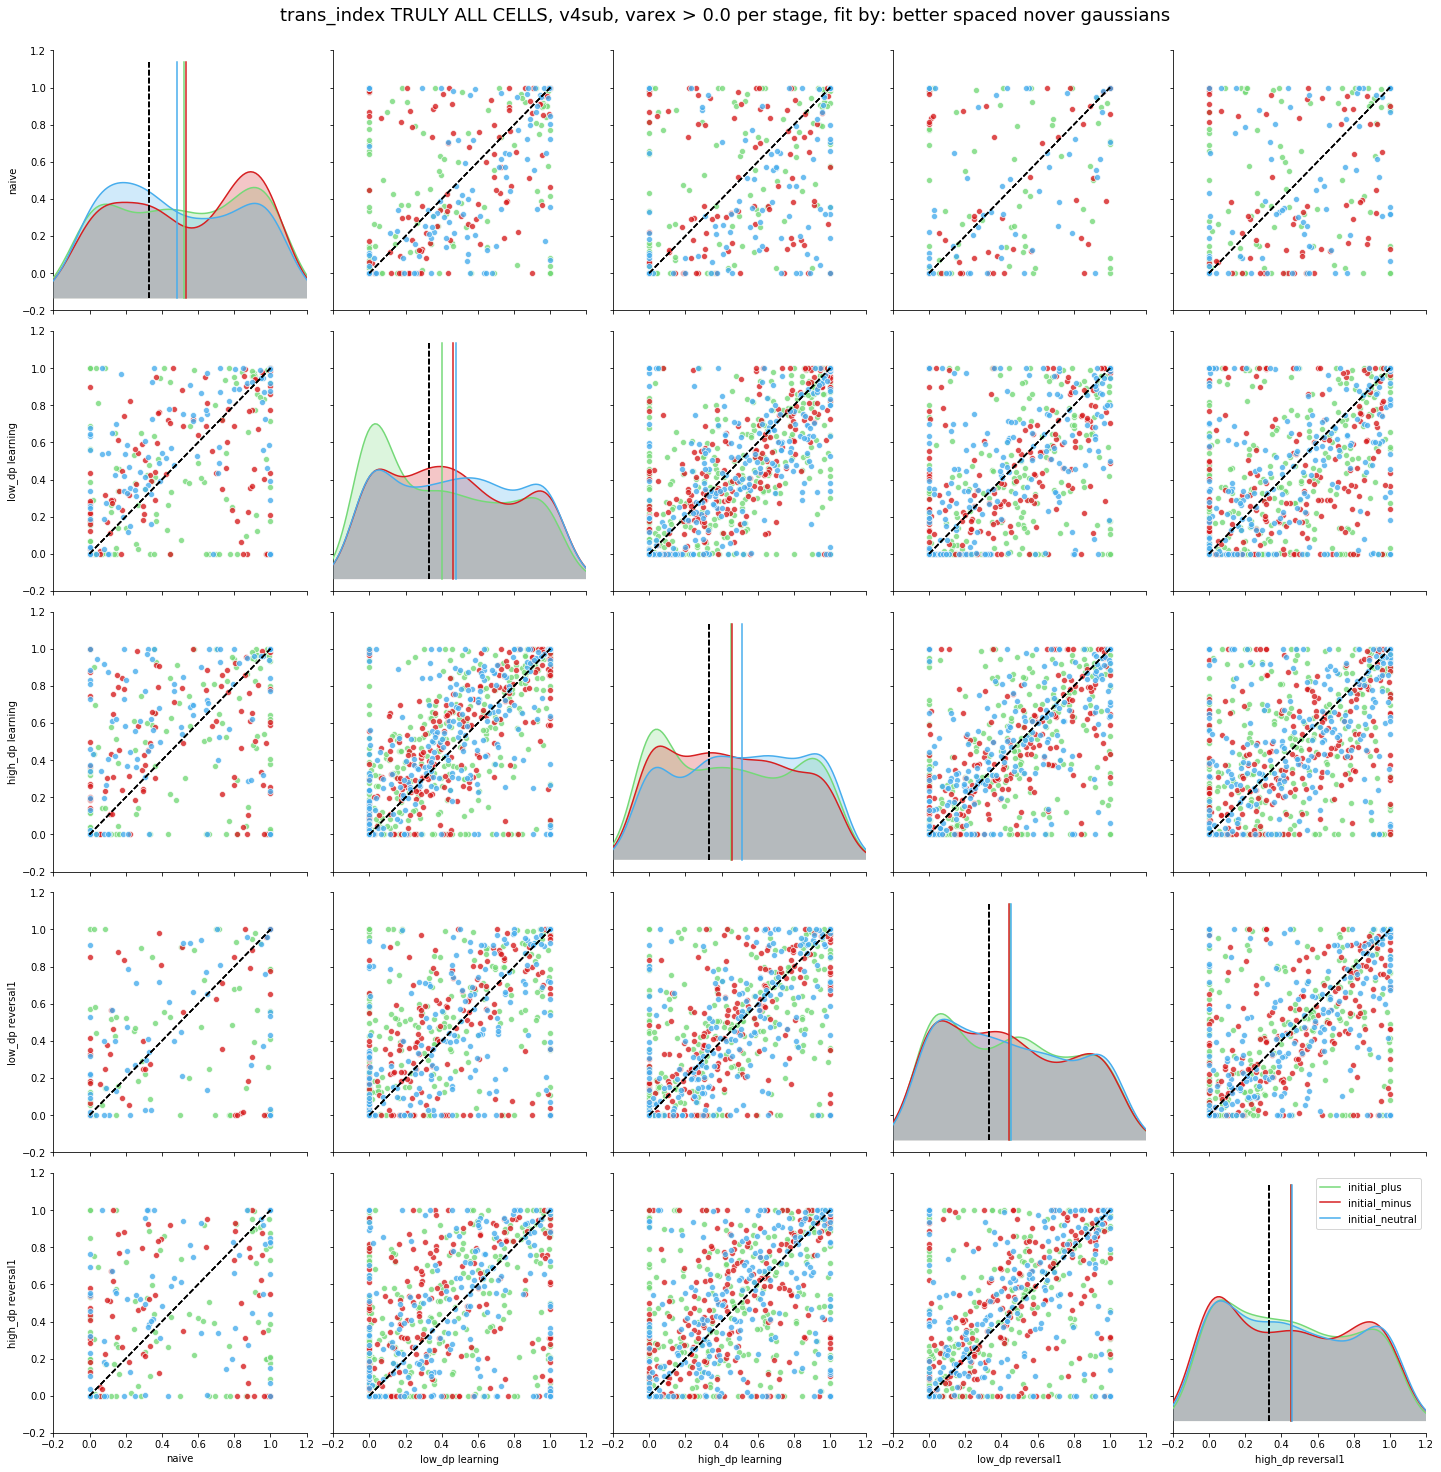

In [599]:
response_type = 'trans_index'
new_df_list = []
['plus', 'minus', 'neutral']
for c, oi in enumerate(['plus', 'minus','neutral']):
    plt.figure(figsize=(6,6))
    driven_df = big_df.loc[big_df['driven_by'].isin(['initial_{}'.format(oi)]) & big_df['orientation'].isin(['initial_{}'.format(oi)])]
#     driven_df = big_df.loc[big_df['orientation'].isin(['initial_{}'.format(oi)])]
    resp_df = driven_df.loc[driven_df['response_type'].isin([response_type])]
    new_df_list.append(resp_df)
grid_df = pd.concat(new_df_list, axis=0)
# grid_df = grid_df.fillna(-1)

# useful lookup tables
def originline(a, b, color, label):
    plt.plot([0,1], [0,1], '--k')
#     plt.plot([-3,1], [-3,1], '--k')
#     plt.plot([0,6], [0,6], '--k')
    plt.ylim([-0.2,1.2])
    plt.xlim([-0.2,1.2])
    
# useful lookup tables
def originline2(a, color, label):
#     plt.plot([0.5, 0.5], [0,2], '--k')
    plt.plot([0.33, 0.33], [0,2], '--k')
    test = np.nanmean(a)
    plt.plot([test, test], [0,2], color=color)
#     print(a, len(a))
#     asd
    
hue_dict = {'initial_plus': [0.46, 0.85, 0.47, 1],
     'initial_minus': [0.84, 0.12, 0.13, 1],
     'initial_neutral': [0.28, 0.68, 0.93, 1],
     'learning': [34/255, 110/255, 54/255, 1],
     'reversal': [173/255, 38/255, 26/255, 1],
     'gray': [163/255, 163/255, 163/255, 1]}
# g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
#        'response_type', 'driven_by']).drop(columns='naive'), hue='orientation', palette=hue_dict, height=4)
g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
       'response_type', 'driven_by']), hue='orientation', palette=hue_dict, height=4)
# g = sns.PairGrid(grid_df.set_index(['cell_number',
#        'response_type', 'driven_by', 'orientation']).drop(columns='naive'), hue='mouse', height=4)
# g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
g = g.map_offdiag(sns.scatterplot, alpha=0.8)
# g = g.map_offdiag(sns.regplot)
g = g.map_offdiag(originline)
g = g.map_diag(sns.kdeplot, shade=True)
# g = g.map_diag(sns.distplot)
g = g.map_diag(originline2)
plt.suptitle('{} TRULY ALL CELLS, v4sub, varex > 0.0 per stage, fit by: better spaced nover gaussians'.format(response_type), y=1.02, size=18)
plt.legend()
# plt.savefig('{}_TRULYALLCELLS_allstage_v4sub_trials_fit_by_nover_gaus_wnaive_wvarex0perstage.pdf'.format(response_type), bbox_inches='tight')

### 10 gaussian - NNLS fitting on all cells over all time

In [467]:
fits_10gauss = {}
fits_10gauss_varex = {}
daily_avg_dict_10gauss = {}
oris = [0, 135, 270]
# A = np.vstack(norm_gker).T
for mi, proj, meti in zip(mice, tensor_list, meta_list):
    
    meti = _update_meta_date_vec(meti)
    meti = _update_meta_stages(meti)
    A = _get_fitting_template_10gaus()
    all_ori = meti['orientation'].values
    all_days = meti.reset_index()['parsed_stage'].values
    u_days = meti.reset_index()['parsed_stage'].unique()
    firsty = _first100_wtrans_bool(meti)

    eng_boo = meti['hmm_engaged'].values | meti['learning_state'].isin(['naive']).values
    
    daily_avg_dict_10gauss[mi] = {}
    fits_10gauss[mi] = {}
    fits_10gauss_varex[mi] = {}
    
    end = 5 + 1
    endsec = 4
    if mi in ['OA32', 'OA34', 'OA36']:
        end = 3 + 1
        endsec = 3
    endframe = int(np.floor(endsec*15.5))
    
    A = A[:endframe, :]
    A = A[:, np.max(A, axis=0) == 1]
    
    for ori in oris:
        cell_mat = np.zeros((proj.shape[0], proj.shape[1], len(u_days)))
        for dc, day_i in enumerate(u_days):
            day_ori_bool = (all_ori == ori) & (all_days == day_i) & firsty
            for c_n in range(cell_mat.shape[0]):
#                     driven_boo = simp_comp_proj_list[mi][comp_n][c_n, :] > 0
                if np.sum(day_ori_bool) > 0:
#                 if np.sum(driven_boo & day_ori_bool) > 0:
                    cell_mat[c_n, :, dc] = np.nanmean(proj[c_n, :, day_ori_bool & eng_boo], axis=0)
#                         cell_mat[c_n, :, dc] = np.nanmean(proj[comp_n][c_n, :, driven_boo & day_ori_bool & eng_boo], axis=0)
        all_tr = np.zeros((proj.shape[0], A.shape[1], len(u_days)))
        all_varex = np.zeros((proj.shape[0], 1, len(u_days)))
        for tr_n in range(cell_mat.shape[2]):
            for c_n in range(cell_mat.shape[0]):
                b = deepcopy(cell_mat[c_n, :, tr_n])
                b[b < 0] = 0
                b = b/np.nanmax(b) # normalize to max (we just care about shape)
                b = b[:endframe]
                if np.sum(np.isnan(b)) == len(b):
                    sp_ans = np.zeros(A.shape[1])
                    sp_ans[:] = np.nan
                    sp_ans = sp_ans
                    varex = np.nan
                else:
                    sp_ans = sp.optimize.nnls(A, b)[0]
                    recon = A@sp_ans[:, None].flatten()
                    varex = 1 - np.var(b-recon)/np.var(b)
#                     varex = np.corrcoef(b, y=recon)[0,1]
                
                end = 5
                if mi in ['OA32', 'OA36', 'OA34']:
                    end = 3
                if np.sum(sp_ans[0:end+1]) == 0:
                    sp_ans[0:end+1] = np.nan
#                     print('   double zero fit')
                    
                all_tr[c_n, :, tr_n] = sp_ans
                all_varex[c_n, :, tr_n] = varex
        fits_10gauss[mi]['ori_{}'.format(ori)] = all_tr
        fits_10gauss_varex[mi]['ori_{}'.format(ori)] = all_varex
        fits_10gauss[mi]['trial_inds_{}'.format(ori)] = np.where(all_ori == ori)[0]
        daily_avg_dict_10gauss[mi]['ori_{}'.format(ori)] = cell_mat
        
        print('varex: {}'.format(np.nanmean(all_varex)))

    print('Making progress: {} done.\n'.format(mi))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: All-NaN slice encountered


varex: 0.403568414849293
varex: 0.4442561039850774
varex: 0.4882063928804831
Making progress: OA27 done.

varex: 0.3879081302258678
varex: 0.36277862540570704
varex: 0.4059599306542462
Making progress: VF226 done.

varex: 0.47880842091054165
varex: 0.4410236287028171
varex: 0.41486478573415797
Making progress: OA67 done.

varex: 0.442183320191894
varex: 0.4169158161579252
varex: 0.39067730882783247
Making progress: OA32 done.

varex: 0.3579015389950654
varex: 0.3059594897766201
varex: 0.3247857327730412
Making progress: OA34 done.

varex: 0.4274171987931483
varex: 0.3324974443710962
varex: 0.3287299341586568
Making progress: OA36 done.

varex: 0.3162673359651672
varex: 0.3443007784361294
varex: 0.372176272968104
Making progress: OA26 done.



In [438]:
fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, :]

(703, 4, 5)

Text(0, 0.5, 'fraction of population (kde)')

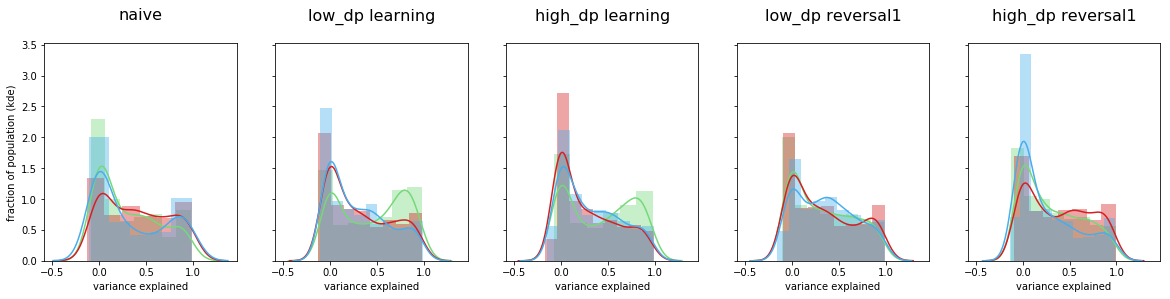

In [468]:
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for stagi in range(5):
    for oik in ['plus', 'minus', 'neutral']:
        alta = fits_10gauss_varex[mi]['ori_{}'.format(lookup[mi][oik])][:, :, stagi].squeeze()
        alta = alta[np.isfinite(alta)]
        sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi])
        ax[stagi].set_title(title_stage[stagi] + '\n', size=16)
    ax[stagi].set_xlabel('variance explained')
ax[0].set_ylabel('fraction of population (kde)')

Text(0, 0.5, 'fraction of population (kde)')

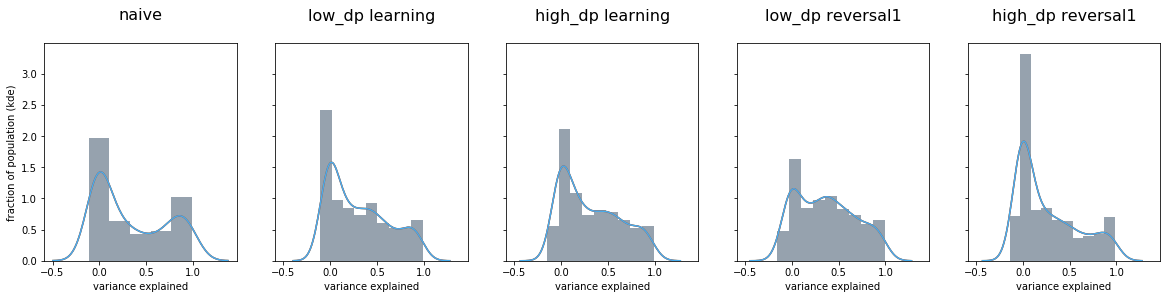

In [439]:
# total variance explained for each cell per stage
title_stage = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for stagi in range(5):
    for oik in ['plus', 'minus', 'neutral']:
        alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, stagi].squeeze()
        alta = alta[np.isfinite(alta)]
        sns.distplot(alta, color=cas.lookups.color_dict[oik], ax=ax[stagi])
        ax[stagi].set_title(title_stage[stagi] + '\n', size=16)
    ax[stagi].set_xlabel('variance explained')
ax[0].set_ylabel('fraction of population (kde)')

In [477]:
jitter_please = False
kill_zeros = False
use_varex= False
varex_thresh = 0.0
varex_thresh_10g = True
use_log10 = False

lookup = cas.lookups.lookup

# plt.figure(figsize=(8,8))
all_ori_list = []
for oi in ['plus', 'minus', 'neutral']:
    done = False
    df_list = []
    for c, mi in enumerate(mice):
        if mi in ['OA36']:
            continue
        if mi in ['OA32', 'OA34', 'OA36']:
            end = 3 + 1
            sus_cols = ['low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
        else:
            end = 5 + 1
            sus_cols = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']

        for wind in ['transient', 'sustained', 'sus_index', 'trans_index', 'vis_stimulus']:
            
#             trans_betas = deepcopy(fits_10gauss[mi]['ori_{}'.format(lookup[mi][oi])][:, 0, :]) 
            trans_betas = np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi][oi])][:, 0:2, :], axis=1)
            sus_betas = np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi][oi])][:, 2:end, :], axis=1)
            stim_betas = np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi][oi])][:, 0:end, :], axis=1)

            if use_varex:
                ori_stage_list = []
                for oik in ['plus', 'minus', 'neutral']:
                    alta = fits_10gauss_varex[mi]['ori_{}'.format(lookup[mi][oik])]
                    ori_stage_list.append(alta.squeeze()[:,:,None])
                all_oris = np.concatenate(ori_stage_list, axis=2)
                max_p = np.nanmax(all_oris, axis=2)
#                     nama = fits_10gauss_varex[mi][comp_n]['ori_{}'.format(lookup[mi][oi])].squeeze()
                nama = max_p
                trans_betas[nama < varex_thresh] = np.nan
                sus_betas[nama < varex_thresh] = np.nan
                stim_betas[nama < varex_thresh] = np.nan
                
            if use_varex_10g:
                ori_stage_list = []
                trans_all_ori_list = []
                sus_all_ori_list = []
                for oik in ['plus', 'minus', 'neutral']:
#                     alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, :]
                    alta = fits_10gauss_varex[mi]['ori_{}'.format(lookup[mi][oik])]
                    ori_stage_list.append(alta.squeeze()[:,:,None])
                all_oris = np.concatenate(ori_stage_list, axis=2)
                max_total = np.nanmax(all_oris, axis=2)
                max_epoch = np.nanmax(max_total, axis=1)
#                 condition_ep_bool = (max_epoch > varex_thresh)
#                 trans_betas[~condition_ep_bool, :] = np.nan
#                 sus_betas[~condition_ep_bool, :] = np.nan
#                 stim_betas[~condition_ep_bool, :] = np.nan
                condition_bool = (max_total > varex_thresh)
                trans_betas[~condition_bool] = np.nan
                sus_betas[~condition_bool] = np.nan
                stim_betas[~condition_bool] = np.nan

            if use_log10:
                trans_betas = np.log10(trans_betas)
                sus_betas = np.log10(sus_betas)
                stim_betas = np.log10(stim_betas)

            # get most driven ori across all stages of learning 
            pa = np.nanmean(np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi]['plus'])][:, 0:end, :], axis=1), axis=1)
            ma = np.nanmean(np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi]['minus'])][:, 0:end, :], axis=1), axis=1)
            na = np.nanmean(np.nanmean(fits_10gauss[mi]['ori_{}'.format(lookup[mi]['neutral'])][:, 0:end, :], axis=1), axis=1)

            pmn_mat = np.vstack([pa, ma, na])
            pmn_text = ['plus', 'minus', 'neutral']
            best_pmn = np.argmax(pmn_mat, axis=0)
            driven_by = ['initial_{}'.format(pmn_text[s]) for s in best_pmn]
            
            if wind == 'transient':
                betas = trans_betas
            elif wind == 'sustained':
                betas = sus_betas
            elif wind == 'sus_index':
                betas = sus_betas/(trans_betas + sus_betas)
            elif wind == 'trans_index':
                betas = trans_betas/(trans_betas + sus_betas)
            elif wind == 'vis_stimulus':
                betas = stim_betas
            
            if kill_zeros:
                betas[betas == 0] = np.nan
                
            if jitter_please:
                jitter_mat = (np.random.rand(betas.shape[0], betas.shape[1]) - 0.5)/25
                betas += jitter_mat

            ori_sus_cols = ['initial_{} {}'.format(oi, s) for s in sus_cols]
            data_df = pd.DataFrame(betas, columns=sus_cols)
            data_df['mouse'] = [mi]*len(data_df)
            data_df['orientation'] = ['initial_{}'.format(oi)]*len(data_df)
            data_df['cell_number'] = np.arange(len(data_df))
            data_df['response_type'] = [wind]*len(data_df)
            data_df['driven_by'] = driven_by

            df_list.append(data_df)
    
    all_mouse_df = pd.concat(df_list, axis=0, sort=False)
    all_ori_list.append(all_mouse_df)

big_df_10gauss = pd.concat(all_ori_list, axis=0)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice


In [68]:
sus_betas.shape

(616, 4, 5)

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

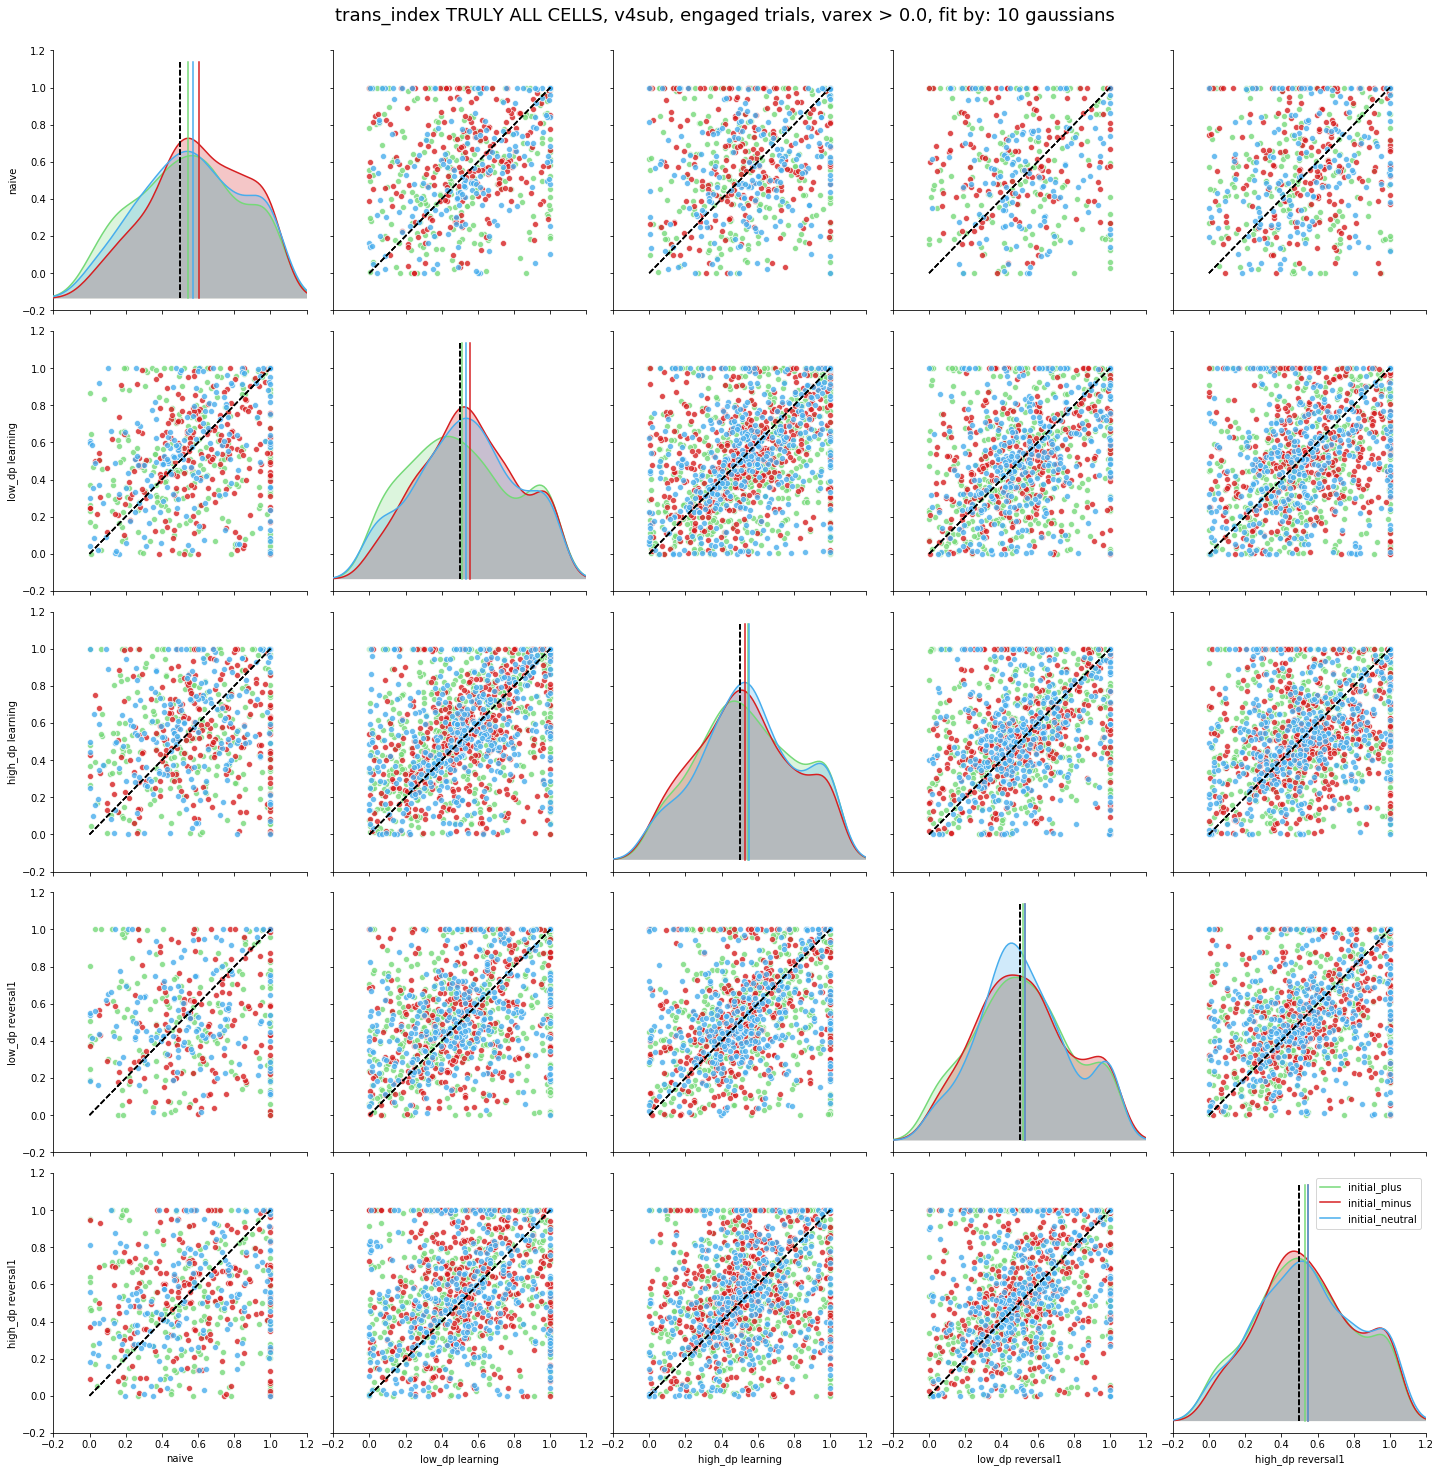

In [478]:
response_type = 'trans_index'
new_df_list = []
# ['plus', 'minus', 'neutral']
for c, oi in enumerate(['plus', 'minus','neutral']):
    plt.figure(figsize=(6,6))
    driven_df = big_df_10gauss.loc[big_df_10gauss['driven_by'].isin(
        ['initial_{}'.format(oi)]) & big_df_10gauss['orientation'].isin(['initial_{}'.format(oi)])]
#     driven_df = big_df_10gauss.loc[big_df['orientation'].isin(['initial_{}'.format(oi)])]
    resp_df = driven_df.loc[driven_df['response_type'].isin([response_type])]
    new_df_list.append(resp_df)
grid_df = pd.concat(new_df_list, axis=0)
# grid_df = grid_df.fillna(-1)

# useful lookup tables
def originline(a, b, color, label):
    plt.plot([0,1], [0,1], '--k')
#     plt.plot([-3,1], [-3,1], '--k')
#     plt.plot([0,6], [0,6], '--k')
    plt.ylim([-0.2,1.2])
    plt.xlim([-0.2,1.2])
    
# useful lookup tables
def originline2(a, color, label):
    plt.plot([0.5, 0.5], [0,2], '--k')
#     plt.plot([0.33, 0.33], [0,2], '--k')
    test = np.nanmean(a)
    plt.plot([test, test], [0,2], color=color)
#     print(a, len(a))
#     asd
    
hue_dict = {'initial_plus': [0.46, 0.85, 0.47, 1],
     'initial_minus': [0.84, 0.12, 0.13, 1],
     'initial_neutral': [0.28, 0.68, 0.93, 1],
     'learning': [34/255, 110/255, 54/255, 1],
     'reversal': [173/255, 38/255, 26/255, 1],
     'gray': [163/255, 163/255, 163/255, 1]}
# g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
#        'response_type', 'driven_by']).drop(columns='naive'), hue='orientation', palette=hue_dict, height=4)
g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
       'response_type', 'driven_by']), hue='orientation', palette=hue_dict, height=4)
# g = sns.PairGrid(grid_df.set_index(['cell_number',
#        'response_type', 'driven_by', 'orientation']).drop(columns='naive'), hue='mouse', height=4)
# g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
g = g.map_offdiag(sns.scatterplot, alpha=0.8)
# g = g.map_offdiag(sns.regplot)
g = g.map_offdiag(originline)
g = g.map_diag(sns.kdeplot, shade=True)
# g = g.map_diag(sns.distplot)
g = g.map_diag(originline2)
plt.suptitle('{} TRULY ALL CELLS, v4sub, engaged trials, varex > 0.0, fit by: 10 gaussians'.format(response_type), y=1.02, size=18)
plt.legend()
plt.savefig('{}_TRULYALLCELLS_v4sub_trials_fit_by_10gaus_wnaive_wvarex0.pdf'.format(response_type), bbox_inches='tight')

### varex from 10 gaussian - NNLS fitting on all cells over all time

In [289]:
def dev_explained(b, recon):
    
    null = np.mean(b)
    dev_mod = np.sum((b - recon)**2)
    dev_null = np.sum((b - null)**2)
    devex_total = 1 - dev_mod/dev_null
    
    return devex_total

STARTING: OA27.

(62, 6)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


   double zero fit
   double zero fit
   double zero fit
varex TOTAL: [0.4860052  0.38924597 0.40301672 0.34011616 0.42221763]
varex trans: [0.22788327 0.18750193 0.22260723 0.1591651  0.22998507]
varex sus: [0.34710289 0.30656802 0.28607038 0.29030445 0.29434121]
varex vis_stim: [0.4860052  0.38924597 0.40301672 0.34011616 0.42221763]

   double zero fit
   double zero fit
   double zero fit
varex TOTAL: [0.48516356 0.43955326 0.40865837 0.40945343 0.48922805]
varex trans: [0.24720909 0.19881072 0.19969883 0.16740498 0.20324188]
varex sus: [0.33371774 0.3519675  0.32251445 0.3509831  0.38692465]
varex vis_stim: [0.48516356 0.43955326 0.40865837 0.40945343 0.48922805]

   double zero fit
   double zero fit
   double zero fit
   double zero fit
varex TOTAL: [0.47253271 0.48676286 0.51517469 0.50450356 0.46516135]
varex trans: [0.24052482 0.19015133 0.22363245 0.21183887 0.20482348]
varex sus: [0.30747684 0.38639853 0.38154673 0.36802978 0.36255259]
varex vis_stim: [0.47253271 0.48676286

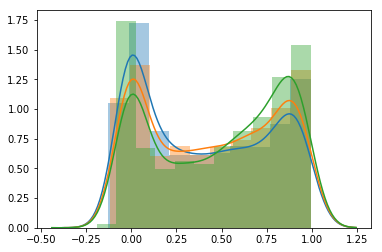

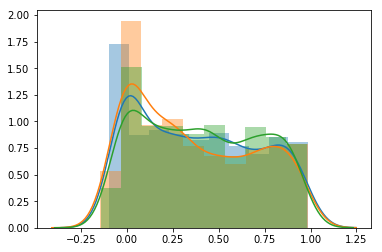

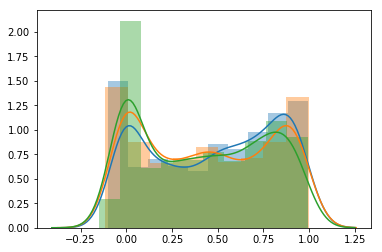

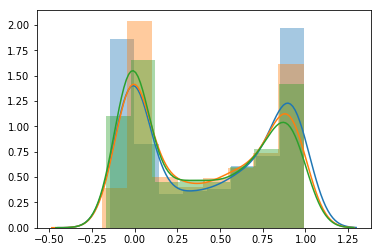

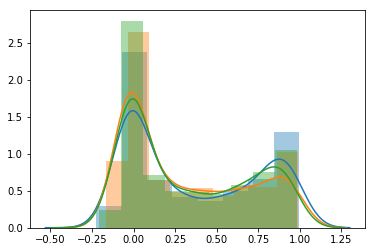

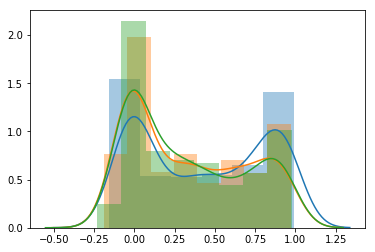

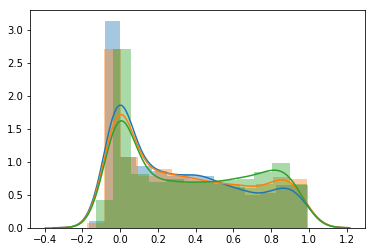

In [376]:
# fits_10var = {}
fits_10var_varex = {}
daily_avg_dict_10var = {}
oris = [0, 135, 270]
# A = np.vstack(norm_gker).T
for mi, proj, meti in zip(mice, tensor_list, meta_list):
    
    print('STARTING: {}.\n'.format(mi))
    
    meti = _update_meta_date_vec(meti)
    meti = _update_meta_stages(meti)
    A = _get_fitting_template_10gaus()
    all_ori = meti['orientation'].values
    all_days = meti.reset_index()['parsed_stage'].values
    u_days = meti.reset_index()['parsed_stage'].unique()
    firsty = _first100_wtrans_bool(meti)

    eng_boo = meti['hmm_engaged'].values | meti['learning_state'].isin(['naive']).values
    
    daily_avg_dict_10var[mi] = {}
    fits_10var[mi] = {}
    fits_10var_varex[mi] = {}
    
    end = 5 + 1
    endsec = 4
    if mi in ['OA32', 'OA34', 'OA36']:
        end = 3 + 1
        endsec = 3
    endframe = int(np.floor(endsec*15.5))
    
    A = A[:endframe, :]
    A = A[:, np.max(A, axis=0) == 1]
    print(A.shape)
    
    plt.figure()
    for ori in oris:
        cell_mat = np.zeros((proj.shape[0], proj.shape[1], len(u_days)))
        for dc, day_i in enumerate(u_days):
            day_ori_bool = (all_ori == ori) & (all_days == day_i) & firsty
            for c_n in range(cell_mat.shape[0]):
#                     driven_boo = simp_comp_proj_list[mi][comp_n][c_n, :] > 0
                if np.sum(day_ori_bool) > 0:
#                 if np.sum(driven_boo & day_ori_bool) > 0:
                    cell_mat[c_n, :, dc] = np.nanmean(proj[c_n, :, day_ori_bool & eng_boo], axis=0)
#                         cell_mat[c_n, :, dc] = np.nanmean(proj[comp_n][c_n, :, driven_boo & day_ori_bool & eng_boo], axis=0)
        all_tr = np.zeros((proj.shape[0], 4, len(u_days)))
#         all_varex = np.zeros((proj.shape[0], 1, len(u_days)))
        for tr_n in range(cell_mat.shape[2]):
            for c_n in range(cell_mat.shape[0]):
                b = deepcopy(cell_mat[c_n, :, tr_n])
                b[b < 0] = 0
                b = b[:endframe]
                if np.sum(np.isnan(b)) == len(b):
                    sp_ans = np.zeros(4)
                    sp_ans[:] = np.nan
                    varex = np.nan
                else:
                    sp_ans = np.zeros(4)
                    sp_ans[:] = np.nan
                    
                    # total varex of model
                    sp_its = sp.optimize.nnls(A, b)[0]
                    recon = A@sp_its[:, None].flatten()
                    total_varex = 1 - np.var(b-recon)/np.var(b)
#                     total_varex = np.corrcoef(b, y=recon)[0, 1]
                    sp_ans[3] = total_varex
        
#                     devex_total = dev_explained(b, recon)
#                     sp_ans[3] = devex_total

                    
                    ablate1 = deepcopy(sp_its)
                    ablate1[0:2] = 0
                    recon_trans = A@ablate1[:, None].flatten()
#                     sp_ans[0] = 1 - np.var(b-recon_trans)/np.var(b)
#                     sp_ans[0] = 1 - np.corrcoef(b, y=recon_trans)[0, 1]/total_varex
                    sp_ans[1] = np.corrcoef(b, y=recon_trans)[0, 1]
#                     sp_ans[1] = dev_explained(b, recon_trans)
#                     if 1 - np.var(b-recon_trans)/np.var(b) < 0:
#                         print(np.var(b-recon_trans)/np.var(b))
#                         plt.plot(b)
#                         plt.plot(recon_trans)
#                         asd
#                     sp_ans[0] = 1 - sp_ans[0]/total_varex
#                     sp_ans[0] = total_varex - sp_ans[0]
                    
                    ablate2 = deepcopy(sp_its)
                    ablate2[2:end] = 0
                    recon_sus = A@ablate2[:, None].flatten()
#                     sp_ans[1] = 1 - np.var(b-recon_sus)/np.var(b)
#                     sp_ans[1] = 1 - np.corrcoef(b, y=recon_sus)[0, 1]/total_varex
                    sp_ans[0] = np.corrcoef(b, y=recon_sus)[0, 1]
#                     sp_ans[0] = dev_explained(b, recon_sus)
#                     sp_ans[1] = 1 - sp_ans[1]/total_varex
#                     sp_ans[1] = total_varex - sp_ans[1]
                    
                    ablate3 = deepcopy(sp_its)
                    ablate3[0:end] = 0
                    recon_vs = A@ablate3[:, None].flatten()
                    sp_ans[2] = sp_ans[3]
#                     sp_ans[2] = 1 - np.var(b-recon_vs)/np.var(b)
#                     sp_ans[2] = 1 - sp_ans[2]/total_varex
#                     sp_ans[2] = total_varex - sp_ans[2]
                
                # if no variance explained comes from stimulus period set to nan
                if sp_ans[2] == 0:
                    sp_ans[0] = np.nan
                    sp_ans[1] = np.nan
                    sp_ans[2] = np.nan
                    sp_ans[3] = np.nan
                    print('   double zero fit')
                    
                all_tr[c_n, :, tr_n] = sp_ans
                all_varex[c_n, :, tr_n] = varex
        fits_10var[mi]['ori_{}'.format(ori)] = all_tr
#         fits_10var_varex[mi]['ori_{}'.format(ori)] = all_varex
        fits_10var[mi]['trial_inds_{}'.format(ori)] = np.where(all_ori == ori)[0]
        daily_avg_dict_10var[mi]['ori_{}'.format(ori)] = cell_mat
        
#         print('varex: {}'.format(np.nanmean(all_varex)))
        print('varex TOTAL: {}'.format(np.nanmean(all_tr[:, 3, :], axis=0)))
        print('varex trans: {}'.format(np.nanmean(all_tr[:, 0, :], axis=0)))
        print('varex sus: {}'.format(np.nanmean(all_tr[:, 1, :], axis=0)))
        print('varex vis_stim: {}\n'.format(np.nanmean(all_tr[:, 2, :], axis=0)))
        
        only_good = all_tr[:, 3, :]
        only_good = only_good[np.isfinite(only_good)]
        sns.distplot(only_good)

    print('Making progress: {} done.\n\n'.format(mi))

array([0.02972074, 0.        , 0.        , 0.00219251, 0.        ,
       0.        ])

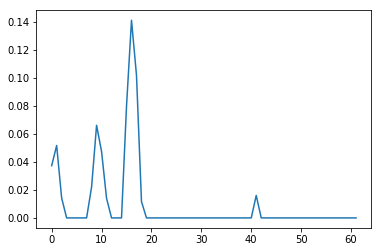

In [303]:
devex_total
plt.plot(b)
sp_its

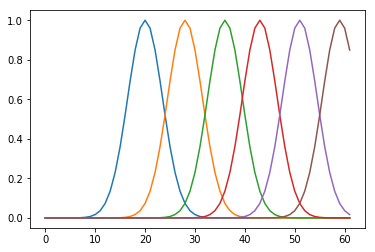

In [234]:
plt.plot(A)

0.1514620665838684

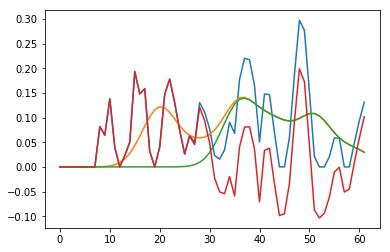

In [334]:
plt.plot(b)
plt.plot(recon)
plt.plot(recon_trans)
plt.plot(b-recon_trans)
dev_explained(b, recon)

Text(0.5, 1.0, '0.8756741057647447')

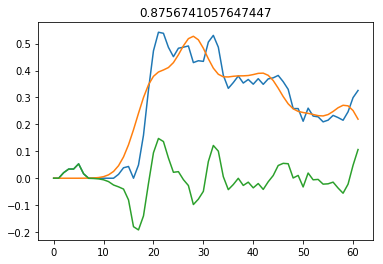

In [240]:
plt.plot(b)
plt.plot(recon)
plt.plot(b-recon)
plt.title(1 - np.var(b-recon)/np.var(b))

array([[0.       , 0.6383848],
       [0.6383848, 0.       ]])

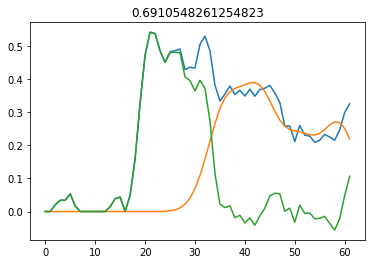

In [247]:
plt.plot(b)
plt.plot(recon_trans)
plt.plot(b-recon_trans)
plt.title(1 - (np.var(b)-np.var(recon_trans))/np.var(b))
1 - np.corrcoef(b, y=recon_trans)

array([[1.       , 0.3616152],
       [0.3616152, 1.       ]])

array([[0.        , 0.42674258],
       [0.42674258, 0.        ]])

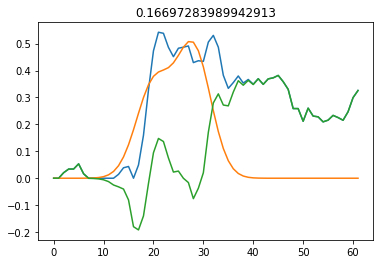

In [248]:
ablate2 = deepcopy(sp_its)
ablate2[2:end] = 0
recon_sus = A@ablate2[:, None].flatten()
plt.plot(b)
plt.plot(recon_sus)
plt.plot(b-recon_sus)
plt.title(1 - np.var(b-recon_sus)/np.var(b))
1 - np.corrcoef(b, y=recon_sus)

array([8.77291592, 8.77291592, 8.74472573, 6.69582922])

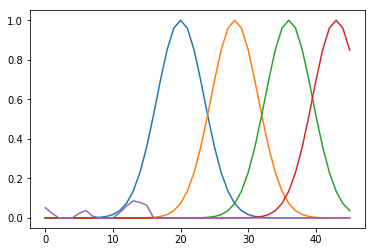

In [144]:
plt.plot(A)
plt.plot(b)
np.sum(A, axis=0)

In [155]:
1 - np.var(b-recon_vs)/np.var(b)

0.0

array([0.06401486, 0.05958316, 0.04805814, 0.03824899, 0.01776023,
       0.09225893])

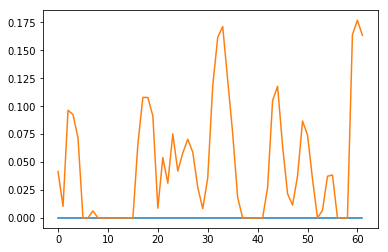

In [156]:
plt.plot(recon_vs)
plt.plot(b)
sp_its

In [393]:
jitter_please = False
kill_zeros = False
use_varex= True
varex_thresh = -10
use_log10 = False

lookup = cas.lookups.lookup

# plt.figure(figsize=(8,8))
all_ori_list = []
for oi in ['plus', 'minus', 'neutral']:
    done = False
    df_list = []
    for c, mi in enumerate(mice):
        if mi in ['OA36']:
            continue
        if mi in ['OA32', 'OA34', 'OA36']:
            sus_cols = ['low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']
        else:
            sus_cols = ['naive', 'low_dp learning', 'high_dp learning', 'low_dp reversal1', 'high_dp reversal1']

        for wind in ['transient', 'sustained', 'sus_index', 'trans_index', 'vis_stimulus']:
            
            trans_betas = deepcopy(fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 0, :])
            sus_betas = deepcopy(fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 1, :])
#             stim_betas = np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 0:2, :], axis=1)
            stim_betas = deepcopy(fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, :])

            if use_varex:
                ori_stage_list = []
                trans_all_ori_list = []
                sus_all_ori_list = []
                for oik in ['plus', 'minus', 'neutral']:
                    alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 3, :]
                    ori_stage_list.append(alta.squeeze()[:,:,None])
                    alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 0, :]
                    trans_all_ori_list.append(alta.squeeze()[:,:,None])
                    alta = fits_10var[mi]['ori_{}'.format(lookup[mi][oi])][:, 1, :]
                    sus_all_ori_list.append(alta.squeeze()[:,:,None])
                all_oris = np.concatenate(ori_stage_list, axis=2)
                max_total = np.nanmax(all_oris, axis=2)
                all_trans = np.concatenate(trans_all_ori_list, axis=2)
                max_trans = np.nanmax(all_trans, axis=2)
                all_sus = np.concatenate(sus_all_ori_list, axis=2)
                max_sus = np.nanmax(all_sus, axis=2)
#                     nama = fits_10var_varex[mi][comp_n]['ori_{}'.format(lookup[mi][oi])].squeeze()
#                 condition_bool = (max_total > varex_thresh) #& ((max_trans > 0) | (max_sus > 0))
#                 trans_betas[~condition_bool] = np.nan
#                 sus_betas[~condition_bool] = np.nan
#                 stim_betas[~condition_bool] = np.nan
                
                max_epoch = np.nanmax(max_total, axis=1)
                condition_ep_bool = (max_epoch > varex_thresh)
                trans_betas[~condition_ep_bool, :] = np.nan
                sus_betas[~condition_ep_bool, :] = np.nan
                stim_betas[~condition_ep_bool, :] = np.nan

            if use_log10:
                trans_betas = np.log10(trans_betas)
                sus_betas = np.log10(sus_betas)
                stim_betas = np.log10(stim_betas)

            # get most driven ori across all stages of learning 
#             pa = np.nanmean(np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['plus'])][:, 0:2, :], axis=1), axis=1)
#             ma = np.nanmean(np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['minus'])][:, 0:2, :], axis=1), axis=1)
#             na = np.nanmean(np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['neutral'])][:, 0:2, :], axis=1), axis=1)
            pa = np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['plus'])][:, 2, :], axis=1)
            ma = np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['minus'])][:, 2, :], axis=1)
            na = np.nanmean(fits_10var[mi]['ori_{}'.format(lookup[mi]['neutral'])][:, 2, :], axis=1)

            pmn_mat = np.vstack([pa, ma, na])
            pmn_text = ['plus', 'minus', 'neutral']
            best_pmn = np.argmax(pmn_mat, axis=0)
            driven_by = ['initial_{}'.format(pmn_text[s]) for s in best_pmn]
            
            if wind == 'transient':
                betas = trans_betas
            elif wind == 'sustained':
                betas = sus_betas
            elif wind == 'sus_index':
                betas = sus_betas/(trans_betas + sus_betas)
            elif wind == 'trans_index':
                betas = trans_betas/(trans_betas + sus_betas)
            elif wind == 'vis_stimulus':
                betas = stim_betas
            
            if kill_zeros:
                betas[betas == 0] = np.nan
                
            if jitter_please:
                jitter_mat = (np.random.rand(betas.shape[0], betas.shape[1]) - 0.5)/25
                betas += jitter_mat

            ori_sus_cols = ['initial_{} {}'.format(oi, s) for s in sus_cols]
            data_df = pd.DataFrame(betas, columns=sus_cols)
            data_df['mouse'] = [mi]*len(data_df)
            data_df['orientation'] = ['initial_{}'.format(oi)]*len(data_df)
            data_df['cell_number'] = np.arange(len(data_df))
            data_df['response_type'] = [wind]*len(data_df)
            data_df['driven_by'] = driven_by

            df_list.append(data_df)
    
    all_mouse_df = pd.concat(df_list, axis=0, sort=False)
    all_ori_list.append(all_mouse_df)

big_df_var10 = pd.concat(all_ori_list, axis=0)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: All-NaN slice encountered
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


In [392]:
trans_betas.shape

(616, 5)

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

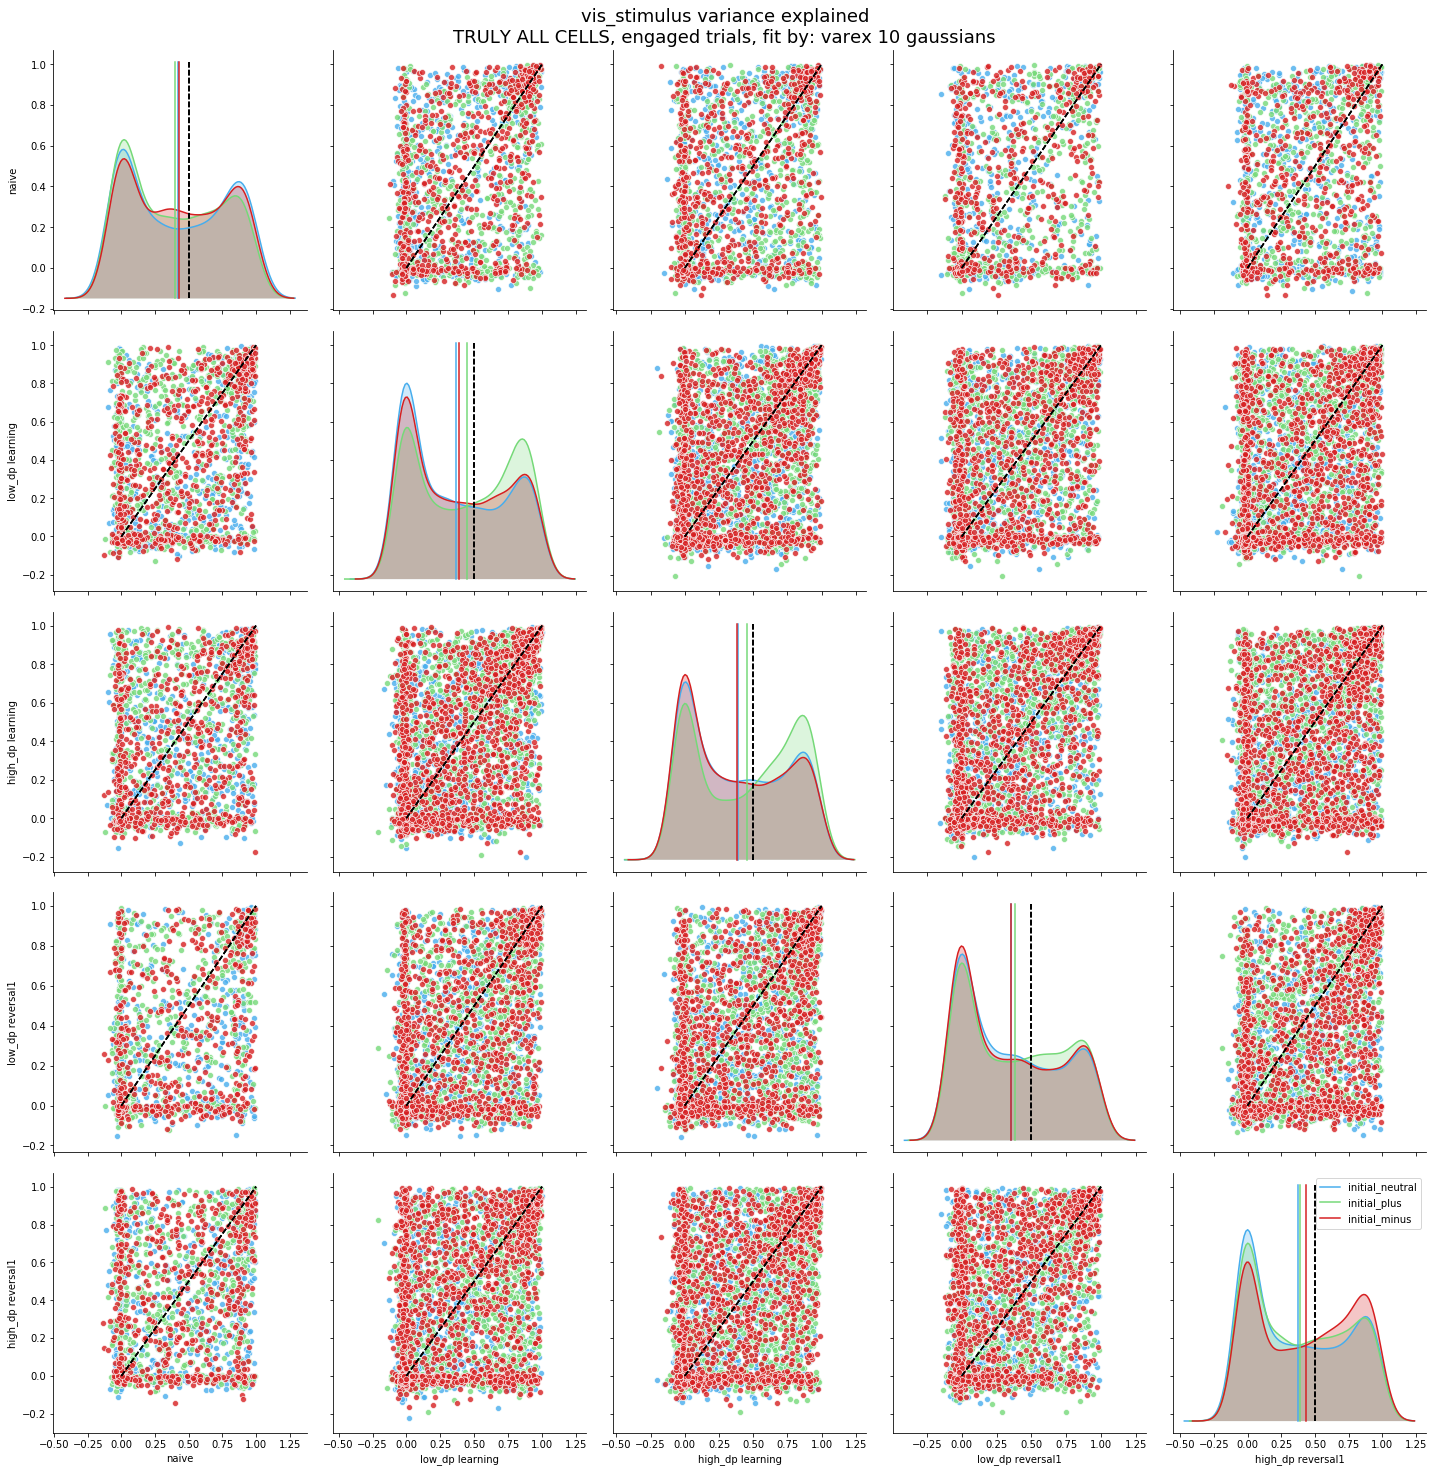

In [395]:
response_type = 'vis_stimulus'
new_df_list = []
# ['plus', 'minus', 'neutral']
for c, oi in enumerate(['neutral', 'plus', 'minus']):
    plt.figure(figsize=(6,6))
#     driven_df = big_df_var10.loc[big_df_var10['driven_by'].isin(['initial_{}'.format(oi)]) & big_df_var10['orientation'].isin(['initial_{}'.format(oi)])]
    driven_df = big_df_var10.loc[big_df['orientation'].isin(['initial_{}'.format(oi)])]
    resp_df = driven_df.loc[driven_df['response_type'].isin([response_type])]
    new_df_list.append(resp_df)
grid_df = pd.concat(new_df_list, axis=0)
# grid_df = grid_df.fillna(-1)

# useful lookup tables
def originline(a, b, color, label):
    plt.plot([0,1], [0,1], '--k')
#     plt.plot([-3,1], [-3,1], '--k')
#     plt.plot([0,6], [0,6], '--k')
#     plt.ylim([-0.2,1.2])
#     plt.xlim([-0.2,1.2])

#     plt.ylim([-0.5,1.5])
#     plt.xlim([-0.5,1.5])

# useful lookup tables
def originline2(a, color, label):
    plt.plot([0.5, 0.5], [0,2], '--k')
#     plt.plot([0.33, 0.33], [0,2], '--k')
    test = np.nanmean(a)
    plt.plot([test, test], [0,2], color=color)
#     print(a, len(a))
#     asd
    
hue_dict = {'initial_plus': [0.46, 0.85, 0.47, 1],
     'initial_minus': [0.84, 0.12, 0.13, 1],
     'initial_neutral': [0.28, 0.68, 0.93, 1],
     'learning': [34/255, 110/255, 54/255, 1],
     'reversal': [173/255, 38/255, 26/255, 1],
     'gray': [163/255, 163/255, 163/255, 1]}
# g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
#        'response_type', 'driven_by']).drop(columns='naive'), hue='orientation', palette=hue_dict, height=4)
g = sns.PairGrid(grid_df.set_index(['mouse', 'cell_number',
       'response_type', 'driven_by']), hue='orientation', palette=hue_dict, height=4)
# g = sns.PairGrid(grid_df.set_index(['cell_number',
#        'response_type', 'driven_by', 'orientation']).drop(columns='naive'), hue='mouse', height=4)
# g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
g = g.map_offdiag(sns.scatterplot, alpha=0.8)
# g = g.map_offdiag(sns.regplot)
g = g.map_offdiag(originline)
g = g.map_diag(sns.kdeplot, shade=True)
# g = g.map_diag(sns.distplot)
g = g.map_diag(originline2)
plt.suptitle('{} variance explained\nTRULY ALL CELLS, engaged trials, fit by: varex 10 gaussians'.format(response_type), y=1.02, size=18)
plt.legend()
plt.savefig('{}_TRULYALLCELLS_VAREX_v2_remdiseng_trials_fit_by_10gaus_wnaive_wvarex.pdf'.format(response_type), bbox_inches='tight')